Ian Norman Ellis

iellis@minevaluation.com

## Forecasting Volcanic Eruption and Impact Assessment

## Problem Statement

The problem at hand entails analyzing a sequence of sensor readings taken at consecutive time steps to address two distinct tasks related to volcanic eruptions. Firstly, the aim is to devise an effective approach that accurately estimates the remaining time units until eruption for a given observation. This observation can have sensor readings of varying lengths. By leveraging the information within the sensor data, the objective is to provide timely predictions for the impending eruption, enabling proactive measures to be taken to ensure the safety of affected areas and populations.

The second task involves estimating the magnitude of the impending volcanic eruption. Utilizing the provided observation, the goal is to develop a methodology that can estimate the severity and intensity of the eruption event. Despite the absence of the eruption magnitude in the observations, it is possible to estimate the tilt erupt value, which represents the last sensor reading corresponding to the moment of eruption. This particular value exhibits a strong correlation with the magnitude of the eruption. By estimating the tilt erupt value, we can obtain a reliable estimation of the eruption's impact. The obtained estimation is crucial for emergency management and response planning, allowing authorities to allocate appropriate resources and implement necessary measures to mitigate the potential impacts of the volcanic eruption on surrounding areas.

### Importing required libraries

In [3]:
%config Completer.use_jedi = False

In [72]:
from collections import namedtuple
import re
import os
import random
import pandas as pd
import numpy as np
import tsfresh
from tsfresh import extract_relevant_features, extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNetCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer
from lazypredict.Supervised import LazyRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA, FactorAnalysis

### Read in data

Store the data we need in a list of namedtuples, with each item corresponding to an observation. From each observation we need the tilt_erupt, the times, and the pressures.

Note that I ran into repeated time indices once (in volcano 6, observation 11, time index -175 is repeated twice), so I'm creating that on my own. If there's a problem with the pressure, there's not much I can do about it at this point.

In [5]:
ObservationData = namedtuple('ObservationData', ['tilt_erupt', 'time', 'pressure', 'name'])
def read_volcano_data(dataset_root):
    data = []
    for root, dirs, files in os.walk(dataset_root):
        for file in files:
            fpath = os.path.join(root, file)
            with open(fpath, 'r') as f:
                name = root[root.rfind('V'):] + '_' + file[:file.rfind('.')]
                fdata = f.readlines()
                # time = np.fromstring(fdata[-2], dtype=int, sep=',')
                pressure = np.fromstring(fdata[-1], sep=',')
                time = np.arange(-len(pressure)+1, 1)
                tilt_erupt = pressure[-1]
                obs_data = ObservationData(tilt_erupt=tilt_erupt, time=time, pressure=pressure, name=name)
                data.append(obs_data)
    return data

data = read_volcano_data('./Volcano_Dataset')

## Visual Data Examination

Let's view the pressure vs time for some of the eruptions to get an understanding of what we're dealing with and see if there's anything obvious that would help with the predictions.

For the most part, the pressure appears to be farily flat before the eruption. In some cases, there's a dip in the pressure before the eruption. Otherwise, there is no obvious indicator that a volcano is about to erupt.

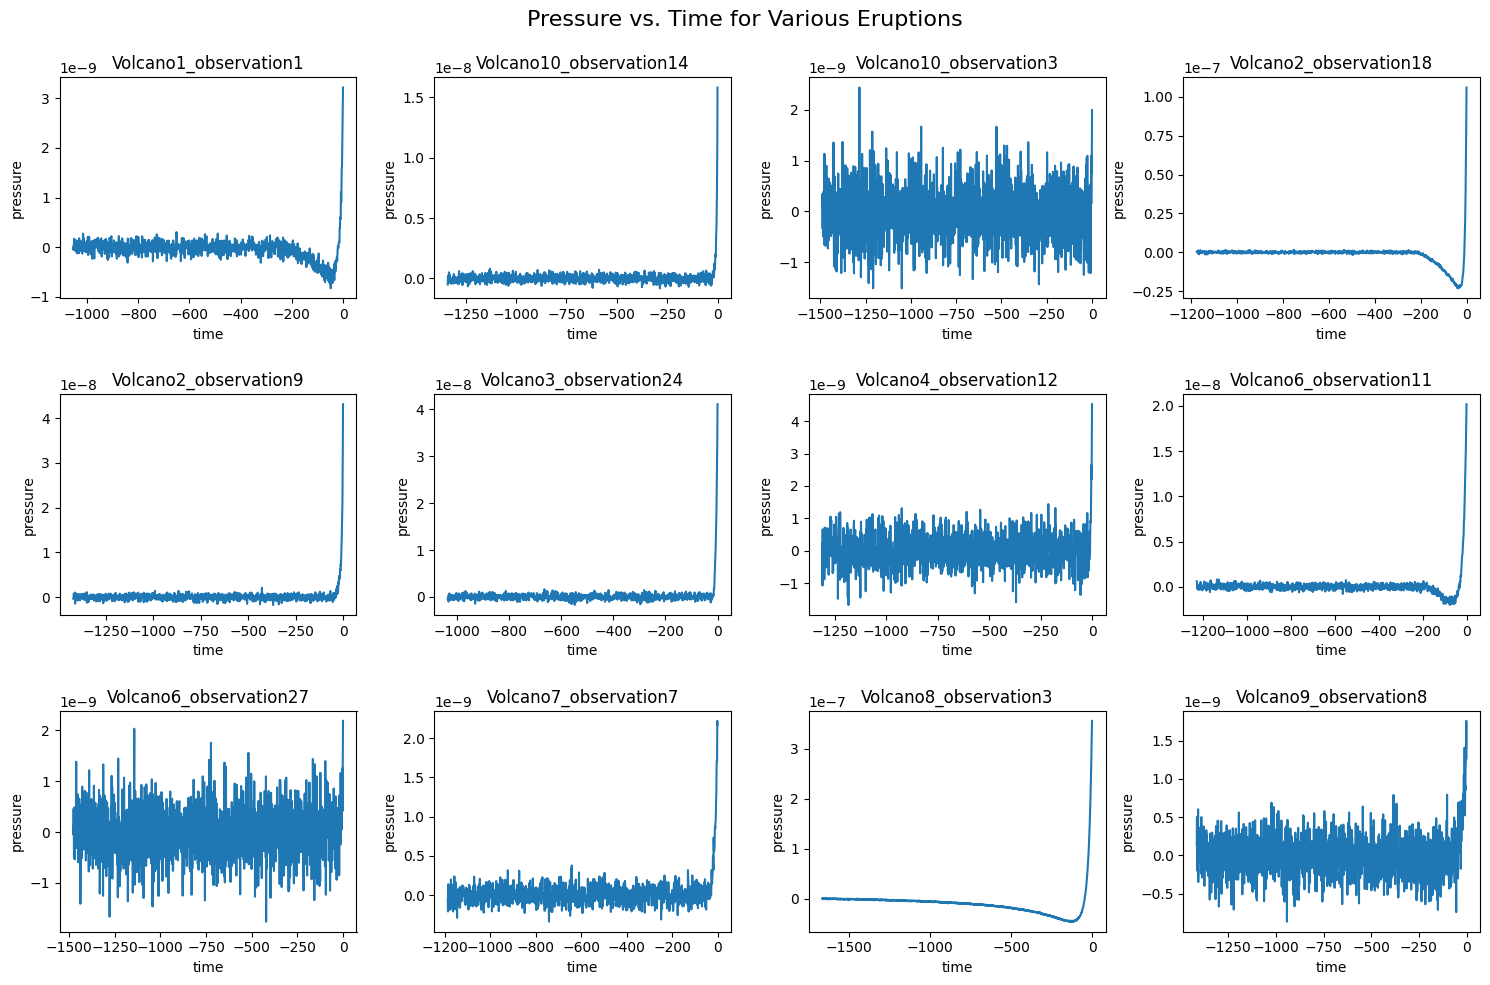

In [6]:
idxs = list(range(0, len(data), 17))

fig, axs = plt.subplots((len(idxs)+3)//4, 4, figsize=(15, 10))
for i, idx in enumerate(idxs):
    axs[i//4, i%4].plot(data[idx].time, data[idx].pressure)
    axs[i//4, i%4].set_xlabel('time')
    axs[i//4, i%4].set_ylabel('pressure')
    axs[i//4, i%4].set_title(data[idx].name)

fig.suptitle('Pressure vs. Time for Various Eruptions', fontsize=16)
fig.tight_layout()



There is a question about whether the data earlier in time is just noise, so I plot the first 750 readings of some of the observations here to see if there are any obvious features. In some of the plots, we can see a clear trend upward or downward in the pressure, as indicated by the trend line.

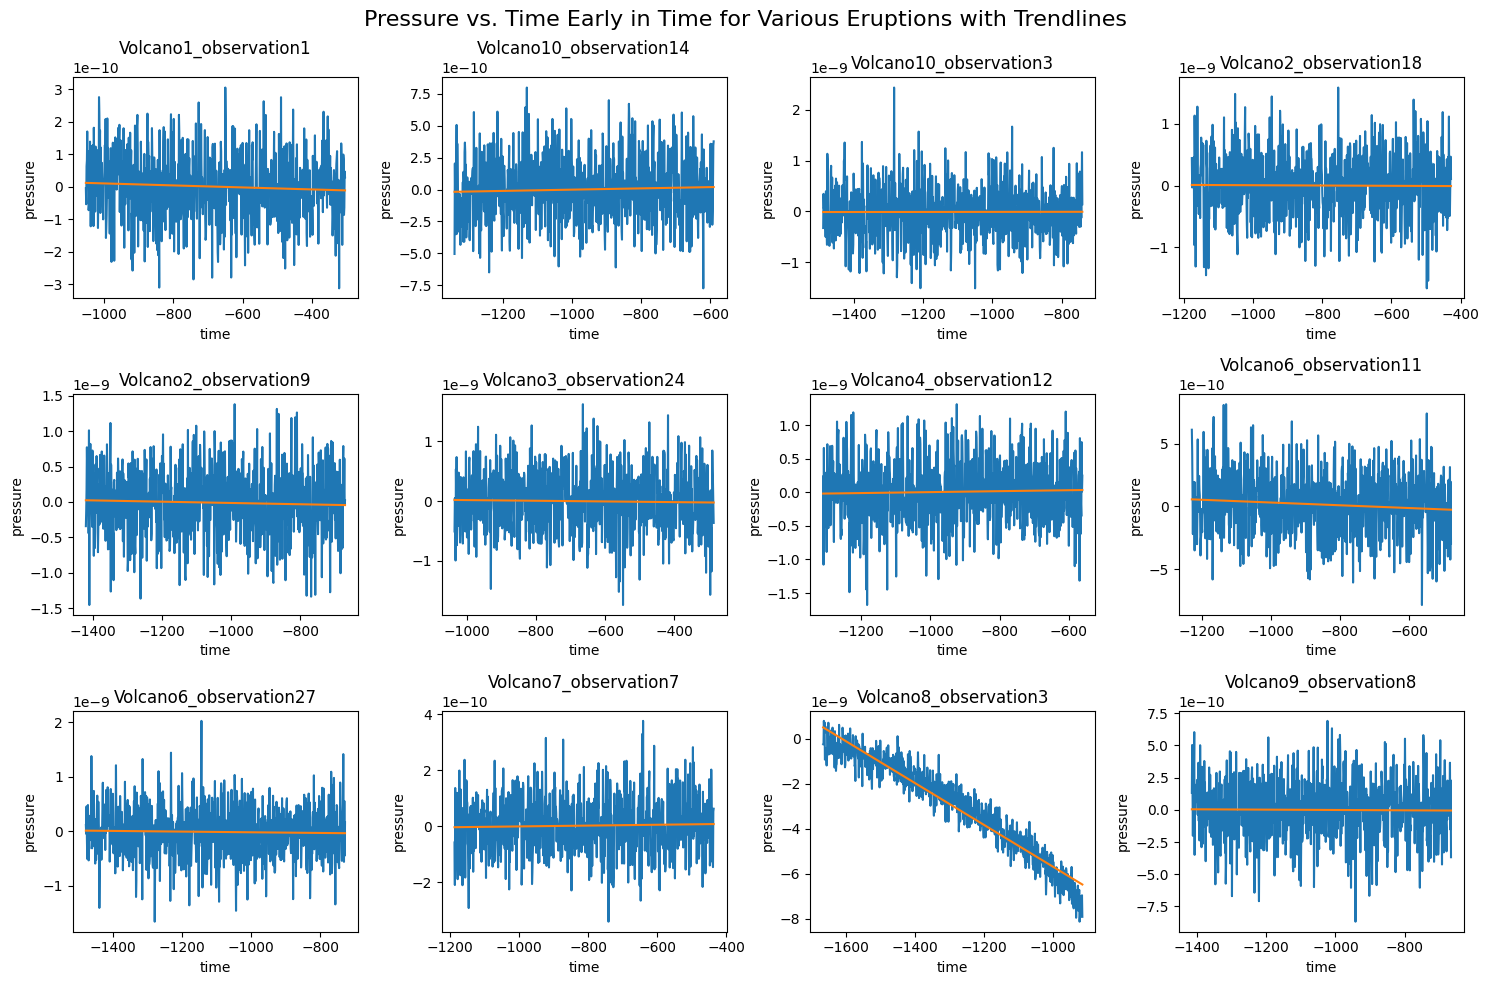

In [7]:
fig, axs = plt.subplots((len(idxs)+3)//4, 4, figsize=(15, 10))
for i, idx in enumerate(idxs):
    t = data[idx].time[:750]
    p = data[idx].pressure[:750]
    axs[i//4, i%4].plot(t, p)
    poly_fit = np.polynomial.polynomial.Polynomial.fit(t, p, 1)
    p_fit = poly_fit.convert().coef[0] + poly_fit.convert().coef[1]*t
    axs[i//4, i%4].plot(t, p_fit)
    axs[i//4, i%4].set_xlabel('time')
    axs[i//4, i%4].set_ylabel('pressure')
    axs[i//4, i%4].set_title(data[idx].name)

fig.suptitle('Pressure vs. Time Early in Time for Various Eruptions with Trendlines', fontsize=16)
fig.tight_layout()

## Test Data

Extract some test observations for the final model evaluation and validation observations for validating various models and techniques. I extract so few test observations (10%) because there's not much data to begin with. I also extract these here to make sure that I have entire observations covered in the validation and test data.

In [8]:
data_train_and_validate, data_test = train_test_split(data, test_size=0.1, random_state=42)
data_train, data_validate = train_test_split(data_train_and_validate, test_size=0.2, random_state=43)

## Time Sequence Extraction

To be useful, the data needs to be transformed into features and a corresponding result that a model can work with. To do so, I first break up the pressure observation into shorter sequences of specified length, then I extract some features from those sequences below. Here, I code up three ways of extracting sequences:

1. sequential: The sequences are consecutive and non-overlapping. The first sequence extraction is shifted so that the last sequence includes time 0.
2. overlapping: Each consecutive sequence overlaps with the previous but is offset by 25 time-steps by default. As with the sequential sequences, the first sequence extraction is shifted so that the last sequence includes time 0.
3. random: A number of sequences equal to the observation length divided by 100 (rounded to the nearest integer) are extracted. The start point of each sequence is chosen at random, but has an upper bound such that an entire sequence can be extracted (e.g. a sequence of length 100 cannot start at time=-50).

In [9]:
def convert_series_to_sequences(eruptions: list, seq_len: int, type='sequential', overlap_step=25, random_seed=5):
    random.seed(random_seed)
    sequences = []
    time_remaining = []
    tilt_erupt = []
    seq_id_start = 0
    for erupt_data in eruptions:
        obs_len = len(erupt_data.pressure)
        if type=='sequential':
            start_offset = obs_len % seq_len
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences(erupt_data, seq_id_start, seq_len, start_offset, seq_len)
        elif type=='overlap':
            start_offset = (obs_len-seq_len) % overlap_step
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences(erupt_data, seq_id_start, seq_len, start_offset, overlap_step)
        elif type=='random':
            sequences0, time_remaining0, tilt_erupt0 = observation_sequences_random(erupt_data, seq_id_start, seq_len)
        else:
            raise Exception('Not a valid sequence extraction type.')
        sequences.extend(sequences0)
        time_remaining.extend(time_remaining0)
        tilt_erupt.extend(tilt_erupt0)
        seq_id_start = sequences0[-1]['sequence id'][0] + 1

    sequences_df = pd.concat(sequences, ignore_index=True)
    time = pd.Series(time_remaining, name='time remaining')
    tilt_erupt = pd.Series(tilt_erupt, name='tilt erupt')
    return sequences_df, time, tilt_erupt

def observation_sequences(obs: ObservationData, seq_id_start: int, seq_len: int, start_offset: int, step_len: int):
    seq_id = seq_id_start
    seqs_dfs = []
    time_remaining = []
    tilt_erupt = []
    obs_len = len(obs.pressure)
    for i in range((obs_len-seq_len) // step_len + 1):
        seq_data = {}
        seq_data['sequence id'] = seq_id*np.ones(seq_len, dtype=pd.Int32Dtype)
        seq_id += 1
        start = start_offset + i*step_len
        seq_data['time'] = obs.time[start:start+seq_len]
        seq_data['pressure'] = obs.pressure[start:start+seq_len]
        seq_df = pd.DataFrame(data=seq_data)
        seqs_dfs.append(seq_df)
        time_remaining.append(-obs.time[start+seq_len-1])
        tilt_erupt.append(obs.tilt_erupt)
        
    return seqs_dfs, time_remaining, tilt_erupt

def observation_sequences_random(obs: ObservationData, seq_id_start: int, seq_len: int):
    seq_id = seq_id_start
    seqs_dfs = []
    time_remaining = []
    tilt_erupt = []
    obs_len = len(obs.pressure)
    start_max = obs_len - seq_len
    n_random_sequences = round(obs_len / 100)
    for _ in range(n_random_sequences):
        seq_data = {}
        seq_data['sequence id'] = seq_id*np.ones(seq_len, dtype=pd.Int32Dtype)
        seq_id += 1
        start = random.randint(0, start_max)
        seq_data['time'] = obs.time[start:start+seq_len]
        seq_data['pressure'] = obs.pressure[start:start+seq_len]
        seq_df = pd.DataFrame(data=seq_data)
        seqs_dfs.append(seq_df)
        time_remaining.append(-obs.time[start+seq_len-1])
        tilt_erupt.append(obs.tilt_erupt)
        
    return seqs_dfs, time_remaining, tilt_erupt
    

For exploratory data analysis, I use a sequence length of 300 with overlapping features. The sequence length is chosen based on some runs with LazyPredict later in the notebook. I choose overlapping features because they ensure lots of data is extracted from each observation, providing a good representation of the variation in each observation.

In [10]:
eda_seq_len = 300
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap')

In [28]:
pd.options.display.float_format = None
pressure_seqs

sequence id  time  pressure
0                 0 -1224  1.40e-10
1                 0 -1223 -6.07e-11
2                 0 -1222  1.93e-10
3                 0 -1221  9.85e-11
4                 0 -1220 -3.52e-10
...             ...   ...       ...
2018695        6728    -4  2.01e-09
2018696        6728    -3  2.64e-09
2018697        6728    -2  2.21e-09
2018698        6728    -1  3.20e-09
2018699        6728     0  4.52e-09

[2018700 rows x 3 columns]

In [101]:
y_time

0       925
1       900
2       875
3       850
4       825
       ... 
6724    100
6725     75
6726     50
6727     25
6728      0
Name: time remaining, Length: 6729, dtype: int32

In [11]:
y_tilt_erupt

0       2.02e-08
1       2.02e-08
2       2.02e-08
3       2.02e-08
4       2.02e-08
          ...   
6724    4.52e-09
6725    4.52e-09
6726    4.52e-09
6727    4.52e-09
6728    4.52e-09
Name: tilt erupt, Length: 6729, dtype: float64

### Manual Feature Extraction

To be useful, the data needs to be transformed into features and a corresponding result that a model can work with. To do so, we break the pressure up into subsequences of a specified length, then perform some calculations of that subsequence to get the features. The time at the end of the subsequence is the time to eruption that we're trying to predict.

The features chosen in this case are:
* Mean
* Median
* Min
* Max
* 25th percentile
* 75th percentile
* Standard Deviation (with 1 degree of freedom)
* Variance (with 1 degree of freedom)
* Skewness
* Kurtosis
* The four coefficients of a 3rd order polynomial fit to the time sequence data
* Moving averages of length 40 every 10 timesteps

Note that the polynomial fit was a basic attempt to get some time-series features into the model. TSFresh will do a much better job of that below.

I explore paring these down after analyzing them for correlations below.

In [100]:
def extract_manual_features(pressure_seqs, y_time, y_tilt_erupt, polynomial_order=3, mv_avg_len=40, mv_avg_step=10):
    seq_len = (pressure_seqs['sequence id'] == 0).sum()
    n_mv_avg = (seq_len - mv_avg_len) // mv_avg_step + 1
    obs_series = []
    for seq_id in range(pressure_seqs['sequence id'].iloc[-1]+1):
        seq = pressure_seqs['pressure'][seq_id*seq_len:(seq_id+1)*seq_len]
        series = {}
        series['mean'] = np.mean(seq)
        series['median'] = np.median(seq)
        series['min'] = np.min(seq)
        series['max'] = np.max(seq)
        series['25th percentile'] = np.percentile(seq, 25)
        series['75th percentile'] = np.percentile(seq, 75)
        series['std dev'] = np.std(seq, ddof=1)
        series['variance'] = np.var(seq, ddof=1)
        series['skew'] = st.skew(seq)
        series['kurtosis'] = st.kurtosis(seq)
        t = np.linspace(0, len(seq)-1, len(seq))
        poly_fit = np.polynomial.polynomial.Polynomial.fit(t, seq, polynomial_order)
        for j, coef in enumerate(poly_fit.convert().coef):
            series[f'poly coef {j}'] = coef
        
        # moving averages
        for avg_i in range(n_mv_avg):
            start = avg_i * mv_avg_step
            end = start + mv_avg_len
            series['moving avg ' + str(avg_i+1)] = np.mean(seq[start:end])
            
        series['time remaining'] = y_time[seq_id]
        series['tilt erupt'] = y_tilt_erupt[seq_id]
        
        series = pd.Series(data = series).to_frame().T
        obs_series.append(series)

    df = pd.concat(obs_series, ignore_index=True)
    df['time remaining'] = df['time remaining'].astype('int32')
    return df

df = extract_manual_features(pressure_seqs, y_time, y_tilt_erupt)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6729 entries, 0 to 6728
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean             6729 non-null   float64
 1   median           6729 non-null   float64
 2   min              6729 non-null   float64
 3   max              6729 non-null   float64
 4   25th percentile  6729 non-null   float64
 5   75th percentile  6729 non-null   float64
 6   std dev          6729 non-null   float64
 7   variance         6729 non-null   float64
 8   skew             6729 non-null   float64
 9   kurtosis         6729 non-null   float64
 10  poly coef 0      6729 non-null   float64
 11  poly coef 1      6729 non-null   float64
 12  poly coef 2      6729 non-null   float64
 13  poly coef 3      6729 non-null   float64
 14  moving avg 1     6729 non-null   float64
 15  moving avg 2     6729 non-null   float64
 16  moving avg 3     6729 non-null   float64
 17  moving avg 4  

In [13]:
df.describe()

mean    median       min       max  25th percentile  \
count  6.73e+03  6.73e+03  6.73e+03  6.73e+03         6.73e+03   
mean  -3.84e-10 -3.35e-10 -1.80e-09  1.86e-09        -7.75e-10   
std    2.57e-09  2.49e-09  5.72e-09  1.65e-08         3.87e-09   
min   -3.67e-08 -3.74e-08 -6.42e-08 -2.51e-08        -4.72e-08   
25%   -1.61e-11 -2.00e-11 -1.40e-09  3.06e-10        -3.31e-10   
50%   -1.18e-12 -1.92e-12 -7.52e-10  7.11e-10        -1.76e-10   
75%    7.80e-12  9.83e-12 -3.37e-10  1.35e-09        -7.63e-11   
max    2.32e-09  2.55e-10 -1.98e-10  4.43e-07        -3.35e-11   

       75th percentile   std dev  variance     skew  kurtosis  ...  \
count         6.73e+03  6.73e+03  6.73e+03  6728.00   6728.00  ...   
mean         -2.26e-11  6.47e-10  8.38e-18     0.05      0.90  ...   
std           1.86e-09  2.82e-09  1.47e-16     0.89      6.62  ...   
min          -3.14e-08  8.60e-11  7.39e-21    -4.96     -1.41  ...   
25%           6.95e-11  1.05e-10  1.10e-20    -0.13     -0.20  ...   
50%           1.66e-10  2.55e-10  6.48e-20    -0.01     -0.03  ...   
75%           3.00e-10  4.98e-10  2.48e-19     0.09      0.19  ...   
max           9.56e-10  6.83e-08  4.67e-15    10.47    121.33  ...   

       moving avg 20  moving avg 21  moving avg 22  moving avg 23  \
count       6.73e+03       6.73e+03       6.73e+03       6.73e+03   
mean       -5.55e-10      -5.99e-10      -6.42e-10      -6.83e-10   
std         3.80e-09       4.03e-09       4.25e-09       4.44e-09   
min        -5.52e-08      -5.87e-08      -6.10e-08      -6.14e-08   
25%        -3.82e-11      -3.86e-11      -3.98e-11      -4.09e-11   
50%        -4.23e-12      -4.45e-12      -4.63e-12      -4.36e-12   
75%         1.99e-11       1.87e-11       1.99e-11       1.93e-11   
max         2.92e-10       3.92e-10       7.96e-10       1.46e-09   

       moving avg 24  moving avg 25  moving avg 26  moving avg 27  \
count       6.73e+03       6.73e+03       6.73e+03       6.73e+03   
mean       -7.17e-10      -7.31e-10      -7.02e-10      -5.38e-10   
std         4.59e-09       4.67e-09       4.74e-09       5.69e-09   
min        -6.01e-08      -6.16e-08      -6.02e-08      -6.10e-08   
25%        -4.28e-11      -4.25e-11      -4.17e-11      -4.18e-11   
50%        -4.81e-12      -4.89e-12      -4.49e-12      -4.18e-12   
75%         1.91e-11       2.00e-11       2.02e-11       2.24e-11   
max         2.40e-09       2.24e-08       6.34e-08       1.32e-07   

       time remaining  tilt erupt  
count         6728.00    6.73e+03  
mean           494.52    4.76e-08  
std            305.60    9.65e-08  
min              0.00    7.37e-10  
25%            225.00    2.82e-09  
50%            475.00    1.58e-08  
75%            725.00    4.16e-08  
max           1350.00    4.43e-07  

[8 rows x 43 columns]

## Multicollinearity

The correlation heatmap displays the correlation between features. In this one, we can see that many features are correlated.

Text(0.5, 1.0, 'Correlation Heatmap')

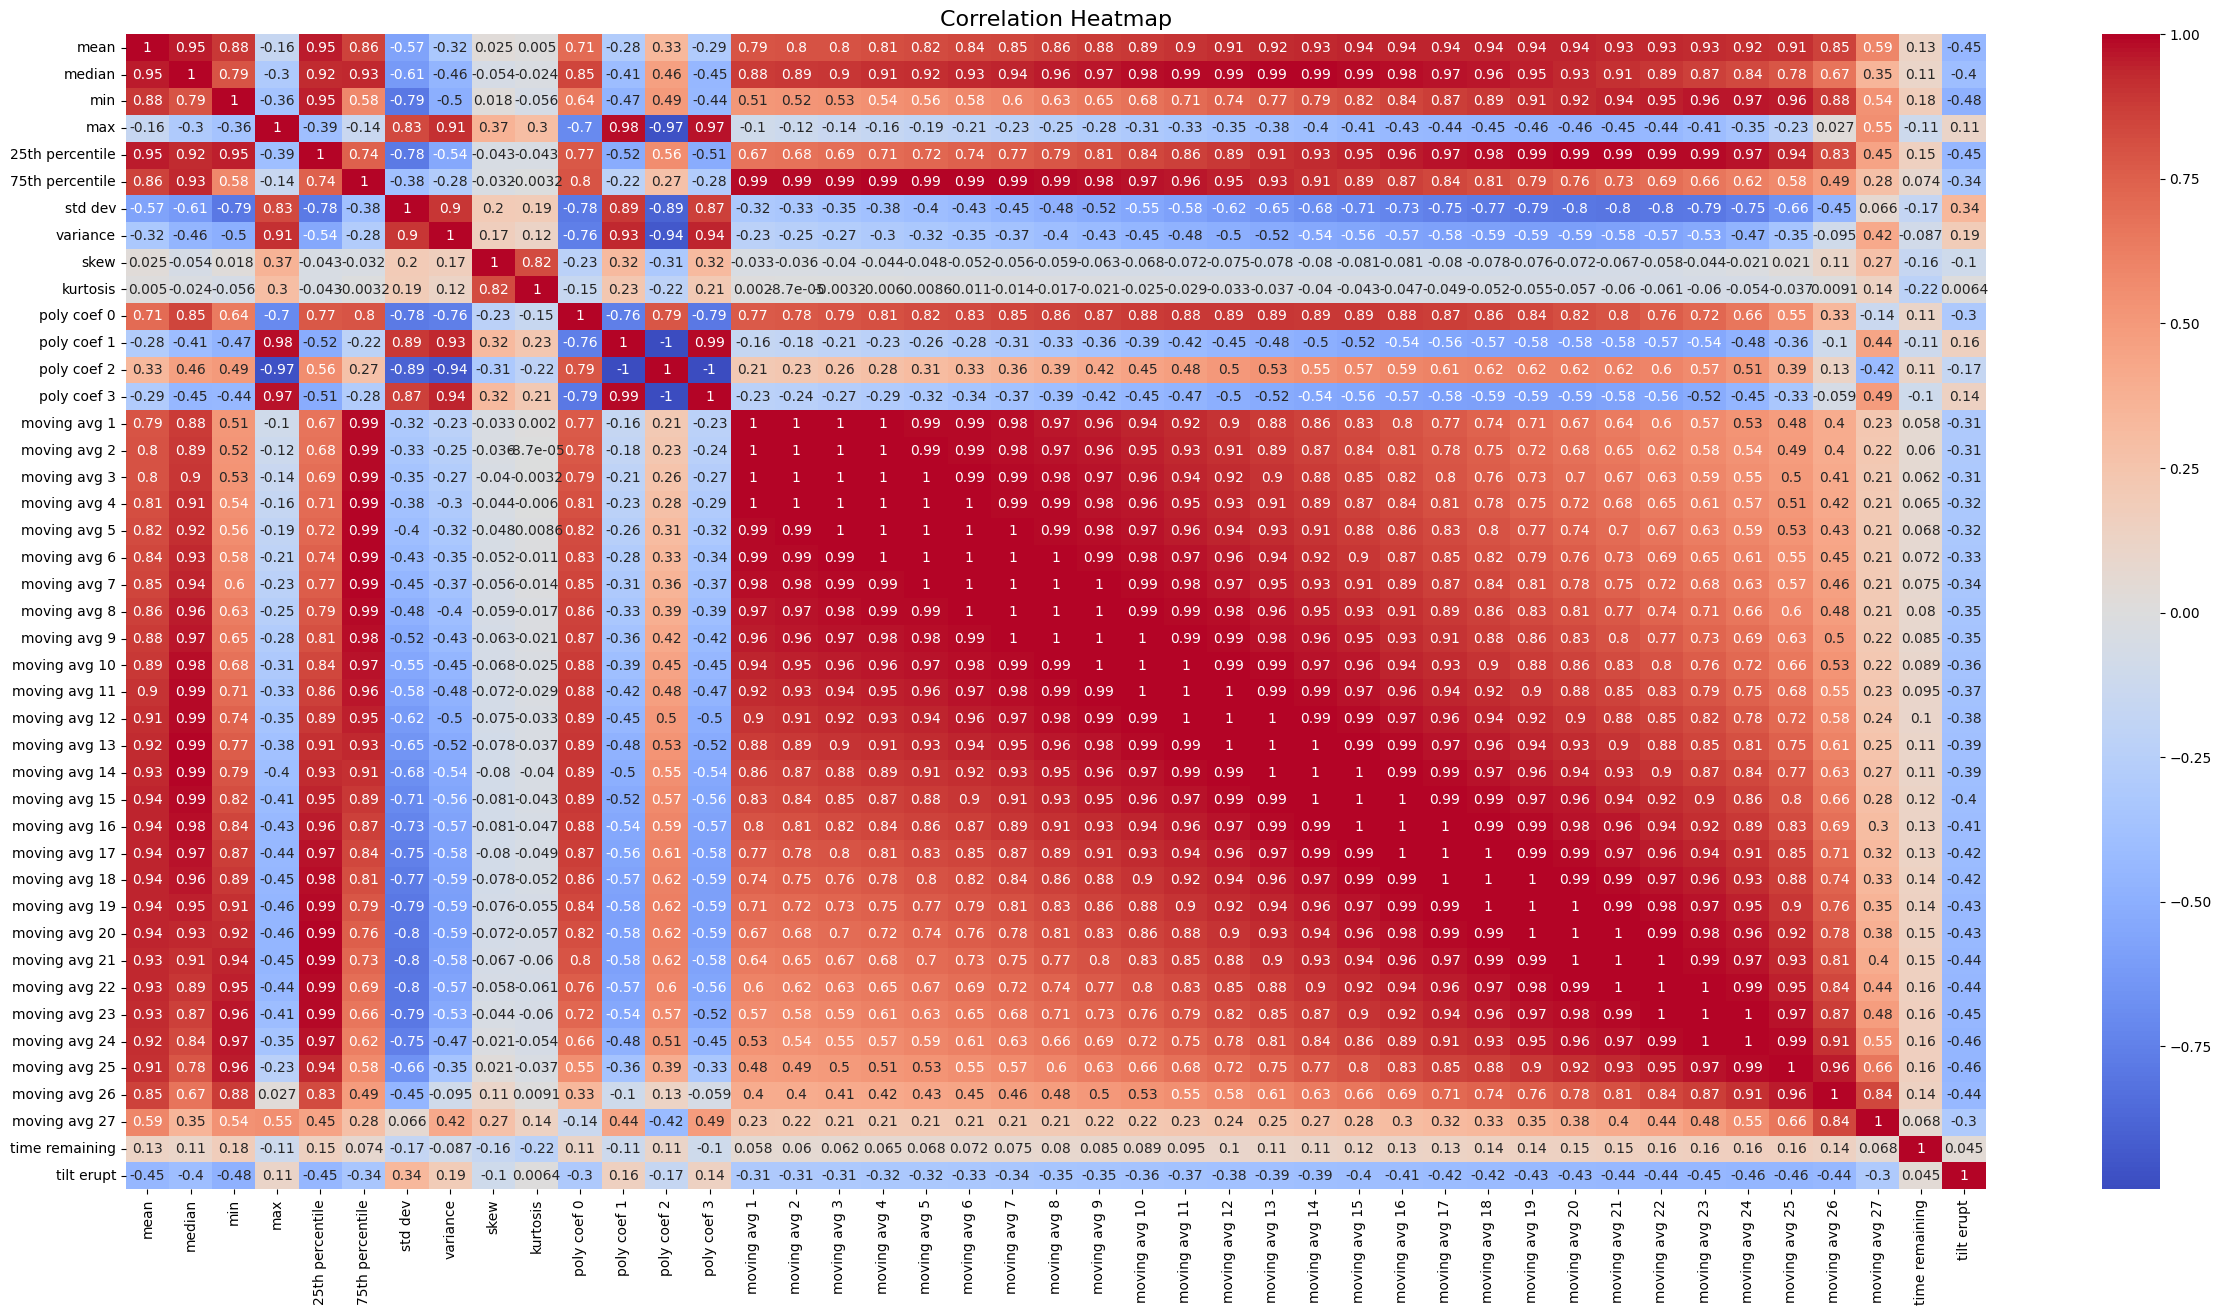

In [12]:
df = extract_manual_features(*convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap'))
corr = df.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)

#### Variance Inflation Factor and Condition Index

To deal with multicollinearity in an automated fashion, we can use the variance inflation factor (VIF). We remove any feature with a VIF > 10. However, we should only remove one feature at a time (the one with the largest VIF) then re-calculate the VIF, as removing a feature affects the VIFs for the other features.

As an alternative, we can use the condition index (based on the eigenvalues of the correlation matrix) to determine multicollinearity. When the condition index > 30, we have strong multicollinearity. However, in the situation below, I see this metric reduce the features down to just three when the VIF reduced it to four. Tests later on will determine whether this further reduction in features is a problem.

There are other options for multicollinearity metrics, which I do not explore here.

In [104]:
def vif_series(X_data):
    return pd.Series([variance_inflation_factor(X_data.values, i) 
               for i in range(X_data.shape[1])], 
              index=X_data.columns)

def condition_index_series(X_data):
    corr = X_data.corr()
    eigenvalues = np.linalg.eigvals(corr)
    return pd.Series(np.sqrt(np.max(eigenvalues)/eigenvalues), index=X_data.columns)

def uncorrelated_features(df_correlated, threshold, metric_function=vif_series):
    if 'time remaining' in df_correlated.columns:
        X_working = df_correlated.drop(columns=['time remaining', 'tilt erupt'])
    else:
        X_working = df_correlated.copy()
    
    if metric_function is vif_series:
        X_working = X_working.assign(const=1)
    
    metrics = metric_function(X_working)
    cols_to_drop = []
    while metrics.max() > threshold:
        cols_to_drop.append(metrics.idxmax())
        X_working.drop(columns=[metrics.idxmax()], inplace=True)
        metrics = metric_function(X_working)
    
    return cols_to_drop, metrics



In [52]:
columns_to_drop, var_inf_factors = uncorrelated_features(df, threshold=10)
print('Remaining features and variance inflation factors:')
var_inf_factors

Remaining features and variance inflation factors:


75th percentile    1.33
std dev            1.26
skew               3.44
kurtosis           3.23
moving avg 27      1.26
const              1.09
dtype: float64

In [53]:
columns_to_drop, cond_idxs = uncorrelated_features(df, threshold=30, metric_function=condition_index_series)
print('Remaining features and condition indicies:')
cond_idxs

Remaining features and condition indicies:


mean                1.00
median              1.77
min                 2.40
max                 4.24
25th percentile    26.89
kurtosis           20.21
dtype: float64

#### Alternative: Principal Component Analysis (PCA) and Factor Analysis (FA)
Principal component analysis and factor analysis are both methods that can be used to reduce the dimensionality of the model. The downside is that they remove the explainability of the model.

I explore using these methods in the modeling below.

<u>Principal Component Analysis</u>

The principal components are the eigenvectors of the covariance matrix, and the corresponding eigenvalues tell us how much variance in the data each principal component exhibits. In the analysis below, I find that almost all (99.4%) of the variance in the features can be explained by one principal component.

In [13]:
pca = PCA(n_components=1)
component_1 = pca.fit_transform(df.drop(columns=['time remaining', 'tilt erupt']))
print(f'Variance explained by first PCA component: {pca.explained_variance_ratio_[0]}')

Variance explained by first PCA component: 0.9942878699206003


Text(0.5, 1.0, 'PCA Component 1')

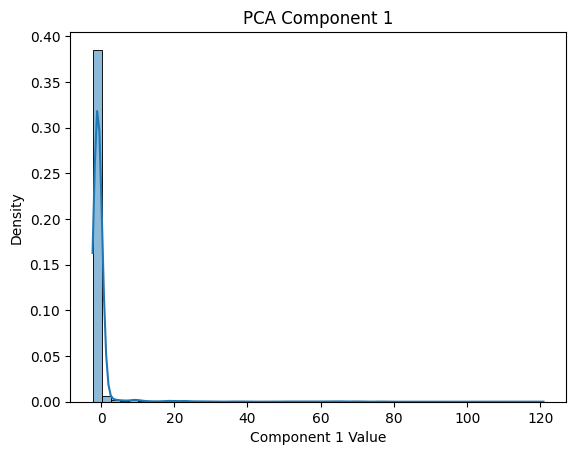

In [14]:
sns.histplot(component_1, kde=True, stat="density", bins=50, legend=None)
plt.xlabel('Component 1 Value')
plt.title('PCA Component 1')

<u>Factor Analysis</u>

A more robust version is known as factor analysis. It works well even if the random variables don't all have the same finite variance (known as heteroscedasticity).

We can see below that, despite the number, all the variation is explained by one component, as was the case with PCA.

In [25]:
def factor_analysis_explained(X_data, n_components):
    fa = FactorAnalysis(n_components=n_components)
    components = fa.fit_transform(X_data)
    fa_loadings = fa.components_.T
    total_var = X_data.var(axis=0).sum()
    var_exp = np.sum(fa_loadings**2, axis=0)
    prop_var_exp = var_exp/total_var

    return components, prop_var_exp

In [26]:
components, prop_var_exp = factor_analysis_explained(df.drop(columns=['time remaining', 'tilt erupt']), 100)
print(f'Variance explained by FA components: {prop_var_exp.round(3)}')
print(f'Cumulative proportion of variance explained by FA components: {np.cumsum(prop_var_exp).round(3)}')

Variance explained by FA components: [0.972 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]
Cumulative proportion of variance explained by FA components: [0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972
 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972
 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972 0.972
 0.972 0.972 0.972 0.972 0.972]


## Outliers

Code for creating box plots of features. I reuse this at least once.

In [56]:
def feature_box_plots(df, cols, title):
    rows = (df.shape[1] + (cols-1))//cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    for i, feature in enumerate(df.columns):
        sns.boxplot(df[feature], ax=axs[i//cols, i%cols])
        axs[i//cols, i%cols].set_title(feature)
        
    fig.suptitle(title)
    fig.tight_layout()

Get the uncorrelated data again for this section just so I'm consistent about what I'm dealing with. I use the variance inflation factor for feature selection.

In [105]:
df = extract_manual_features(*convert_series_to_sequences(data_train_and_validate, seq_len=eda_seq_len, type='overlap'))
columns_to_drop, var_inf_factors = uncorrelated_features(df, threshold=10)
df_uncorrelated = df.drop(columns=columns_to_drop)

Check the description of the uncorrelated features (using VIF). Just by looking at this information, we can see that this is quite a lot of variation in most of the features.

In [106]:
df_uncorrelated.describe()

75th percentile   std dev     skew  kurtosis  moving avg 27  \
count         6.73e+03  6.73e+03  6729.00   6729.00       6.73e+03   
mean         -2.25e-11  6.47e-10     0.05      0.90      -5.38e-10   
std           1.86e-09  2.82e-09     0.89      6.62       5.69e-09   
min          -3.14e-08  8.60e-11    -4.96     -1.41      -6.10e-08   
25%           6.95e-11  1.05e-10    -0.13     -0.20      -4.18e-11   
50%           1.66e-10  2.55e-10    -0.01     -0.03      -4.18e-12   
75%           3.00e-10  4.98e-10     0.09      0.19       2.24e-11   
max           9.56e-10  6.83e-08    10.47    121.33       1.32e-07   

       time remaining  tilt erupt  
count         6729.00    6.73e+03  
mean           494.45    4.76e-08  
std            305.64    9.65e-08  
min              0.00    7.37e-10  
25%            225.00    2.82e-09  
50%            475.00    1.58e-08  
75%            725.00    4.16e-08  
max           1350.00    4.43e-07

There are clearly many statistical outliers in the data, as seen in the plots of uncorrelated features below. However, there is nothing wrong with these outliers, so there's no justification for removing them. However, that doesn't mean that they're not a problem. They can still affect the performance of the model. Therefore, I did a bit of research, and came across the PowerTransformer in scikit-learn. It tranforms the data to make it more Gaussian-like. I explore its effects more below.

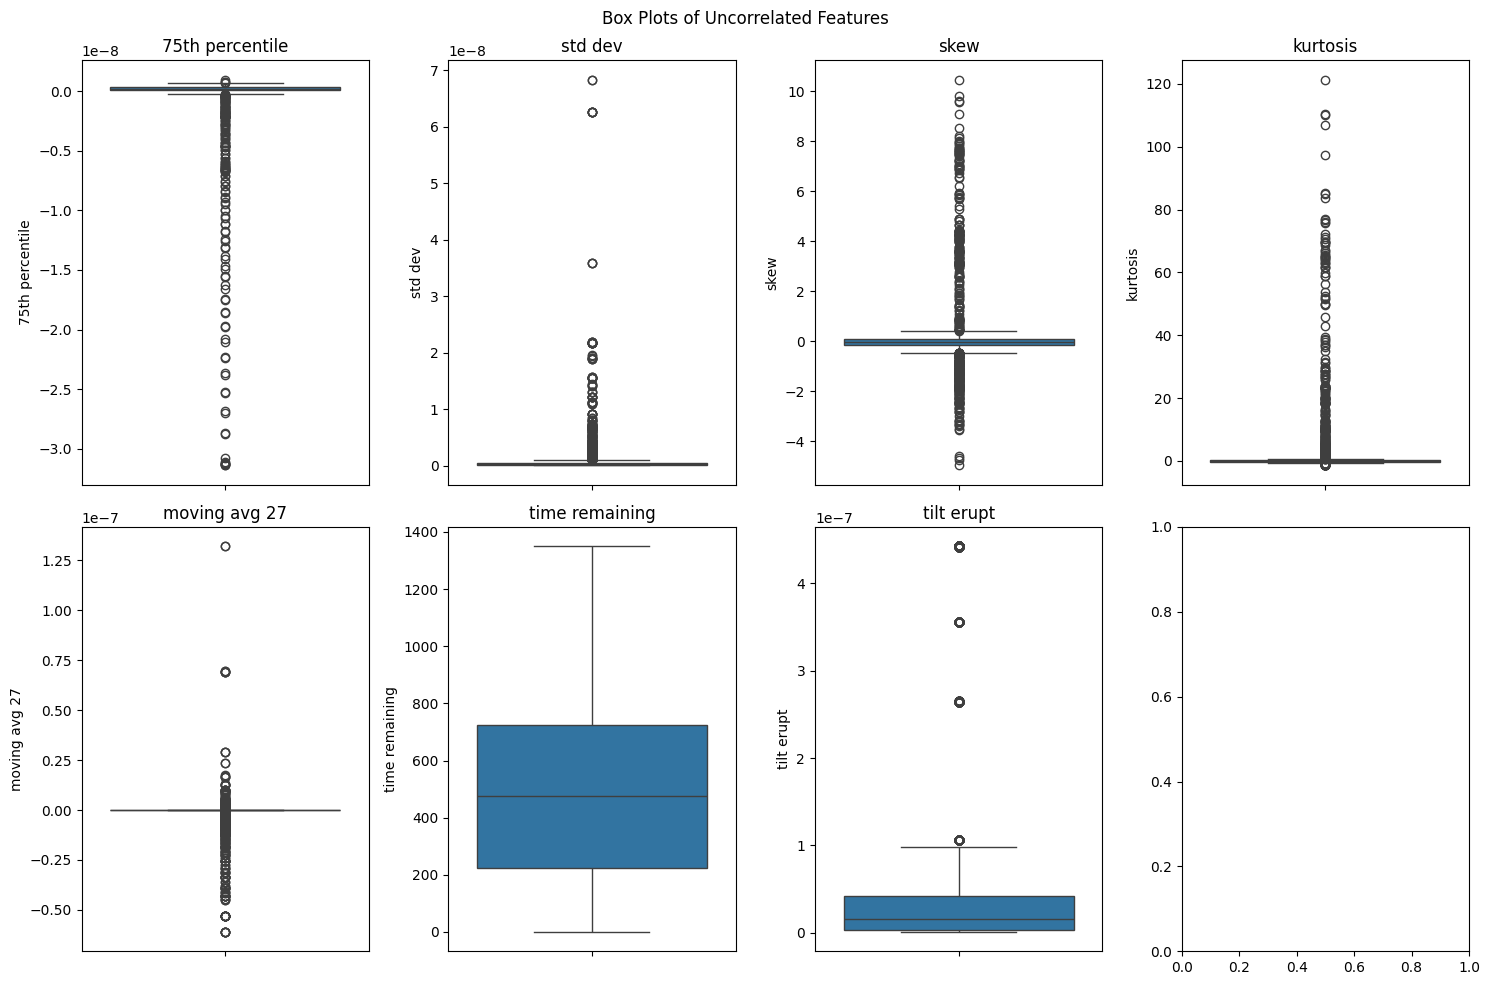

In [57]:
feature_box_plots(df_uncorrelated, cols=4, title='Box Plots of Uncorrelated Features')

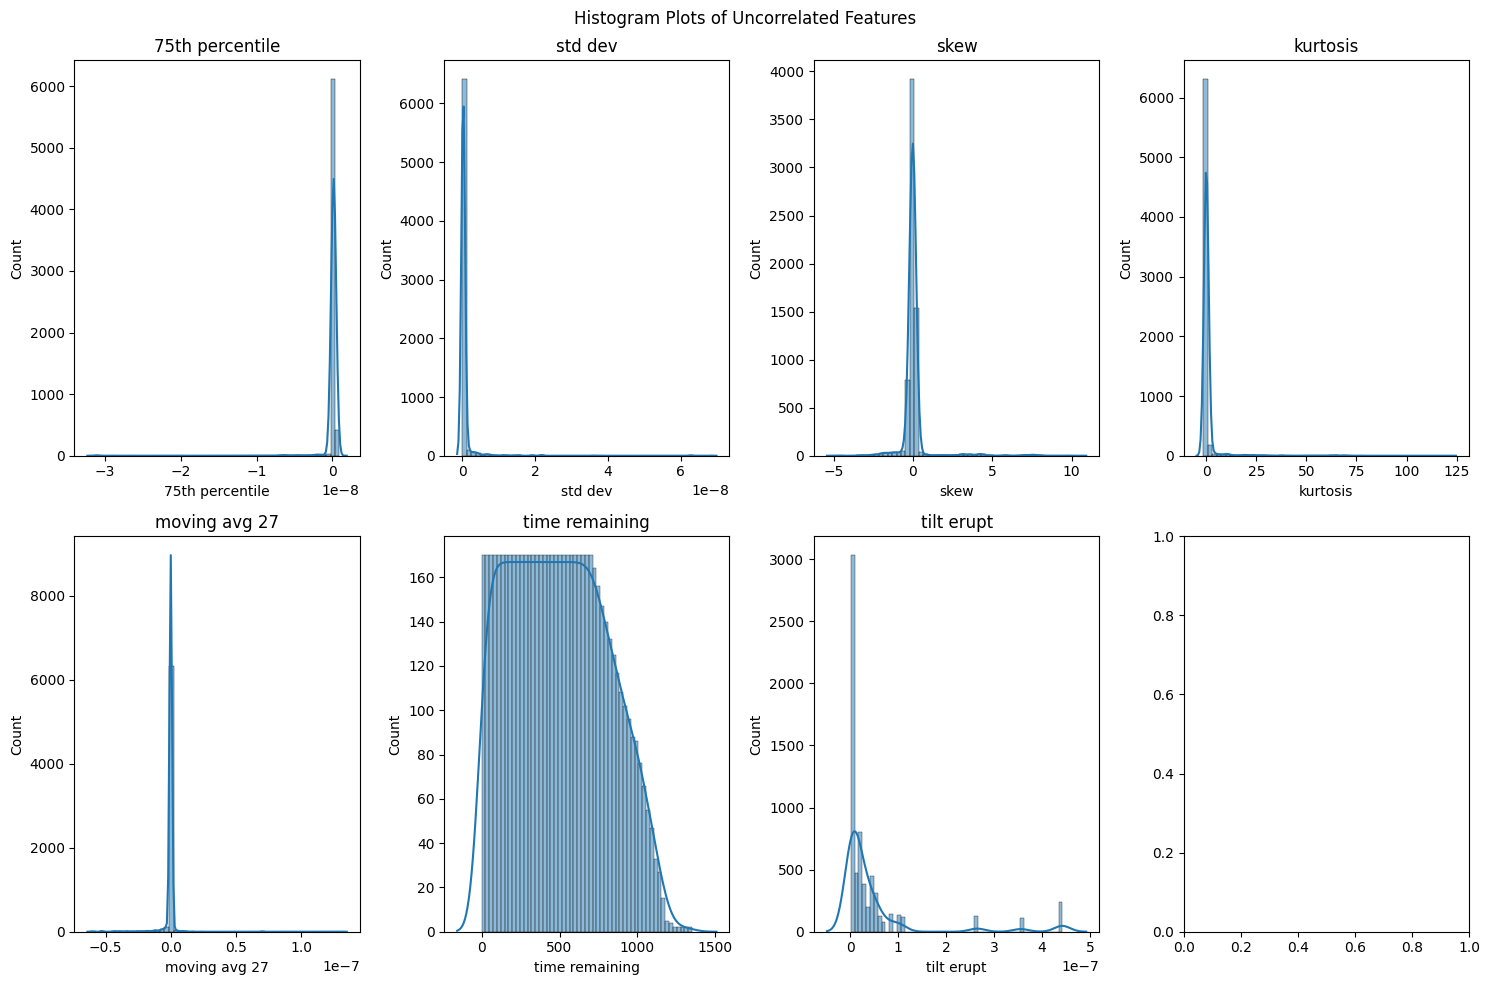

In [66]:
cols=4
rows = (df_uncorrelated.shape[1] + (cols-1))//cols
n_bins = int((max(df_uncorrelated['time remaining']) - min(df_uncorrelated['time remaining'])) / 25 + 1)

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
for i, feature in enumerate(df_uncorrelated.columns):
    sns.histplot(df_uncorrelated[feature], ax=axs[i//cols, i%cols], kde=True, kde_kws=dict(cut=3), bins=n_bins)
    axs[i//cols, i%cols].set_title(feature)
    
fig.suptitle('Histogram Plots of Uncorrelated Features')
fig.tight_layout()

Text(0.5, 1.01, 'Pair Plots for Uncorrelated Features With Outliers')

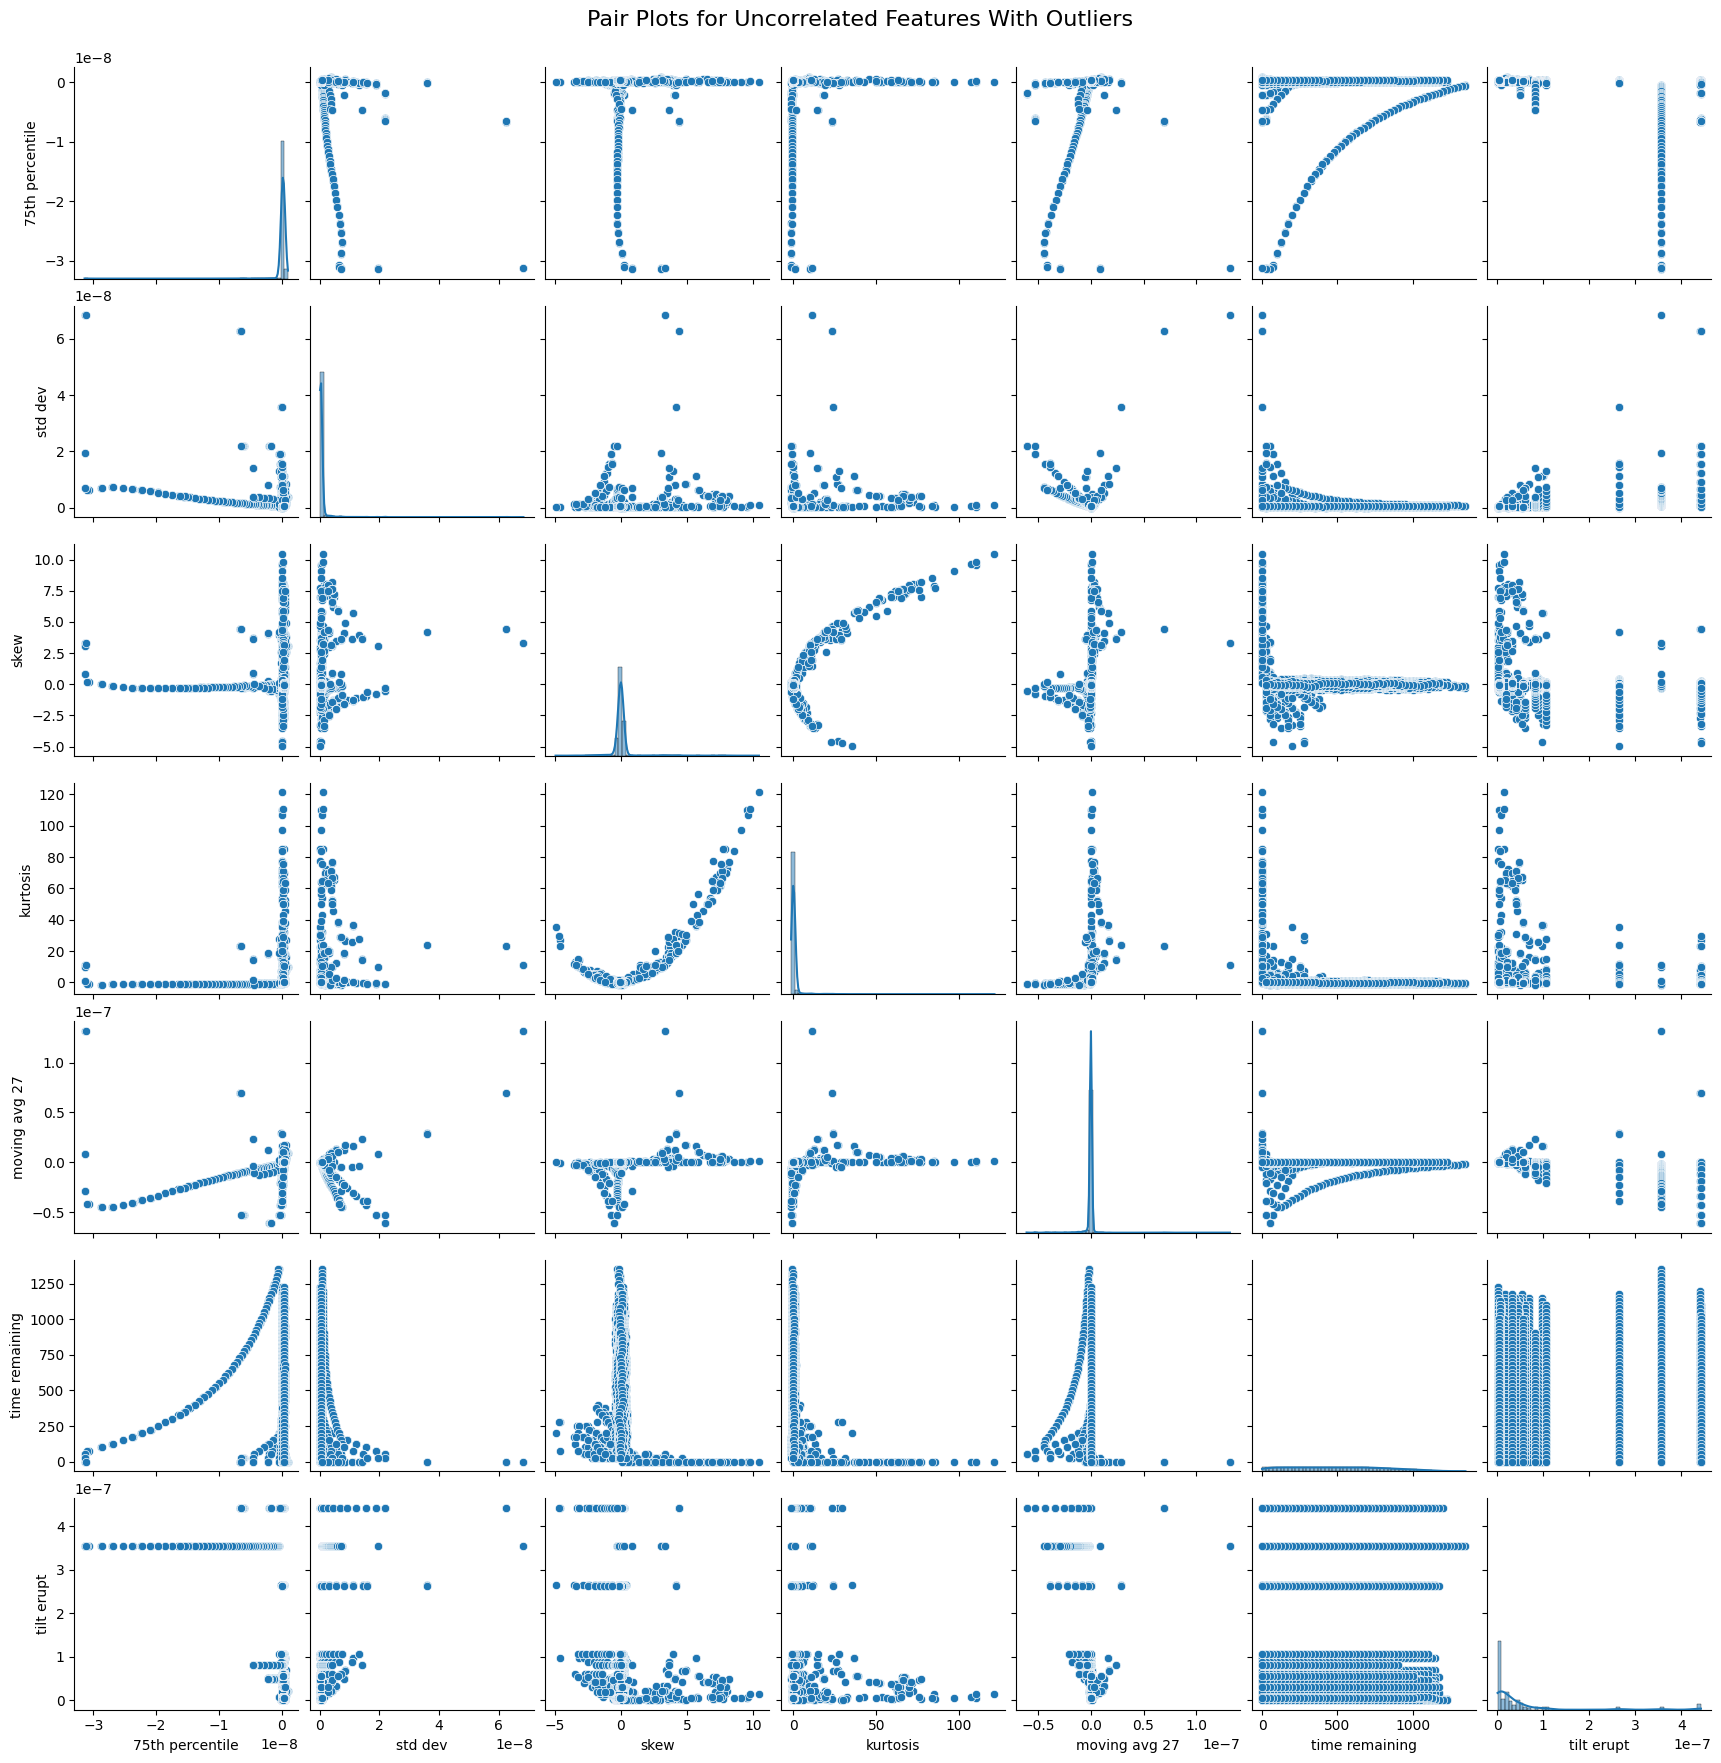

In [67]:
n_bins = int((max(df_uncorrelated['time remaining']) - min(df_uncorrelated['time remaining'])) / 25 + 1)
g = sns.pairplot(df_uncorrelated, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots for Uncorrelated Features With Outliers', y=1.01, fontsize=16)

#### Bad Option: Removing Outliers

Removing the statistical outliers (by the inter-quartile range metric) would prove problematic. As we can see below, it reduces the number of data points from 6729 to 5571, which is perhaps tolerable. However, I have no justification for removing these outliers aside from the fact that they're outliers. They're valid data points, and would likely hurt the model's predicitive power.

We also have the option of just removing rows with outliers in the tilt erupt outcome, but given that we have no way to predict what will be an outlier there without training a model, the option should only be taken with care.

In [17]:
def remove_outliers(df_in, drop_y_outliers=False, drop_only_y_outliers=False):
    y_cols = []
    if 'time remaining' in df_in.columns:
        y_cols.append('time remaining')
    if 'tilt erupt' in df_in.columns:
        y_cols.append('tilt erupt')
    
    if drop_only_y_outliers:
        df_outliers_calc = df_in[y_cols]
    elif drop_y_outliers:
        df_outliers_calc = df_in
    else:
        df_outliers_calc = df_in.drop(columns=y_cols)
      
    q1 = df_outliers_calc.quantile(0.25)
    q3 = df_outliers_calc.quantile(0.75)
    iqr = q3-q1
    if drop_only_y_outliers:
        not_outliers = df_outliers_calc[:][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
        not_outliers = pd.concat([df_in.drop(columns=y_cols), not_outliers], axis=1)
    elif drop_y_outliers:
        not_outliers = df_in[:][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
    else:
        not_outliers = df_in[df_outliers_calc.columns][~((df_outliers_calc<(q1-1.5*iqr)) | (df_outliers_calc>(q3+1.5*iqr)))]
        not_outliers = pd.concat([not_outliers, df_in[y_cols]], axis=1)
    df_no_outliers = not_outliers.dropna()
    
    return df_no_outliers

In [109]:
df_filtered1 = remove_outliers(df_uncorrelated)
print(f'Data points before removing outliers from uncorrelated data: {df_uncorrelated.shape[0]}')
print(f'Data points after removing outliers from uncorrelated data: {df_filtered1.shape[0]}')

Data points before removing outliers from uncorrelated data: 6729
Data points after removing outliers from uncorrelated data: 5571


Removing the outliers in just the independent features (not time remaining or tilt erupt) removes many outlying dots in the scatter plots. Many other feaures disappear as well. I postulate that the three clumps in standard deviation are related to the sigma parameter in the data files.

Text(0.5, 1.01, 'Pair Plots for Uncorrelated Features Without Outliers')

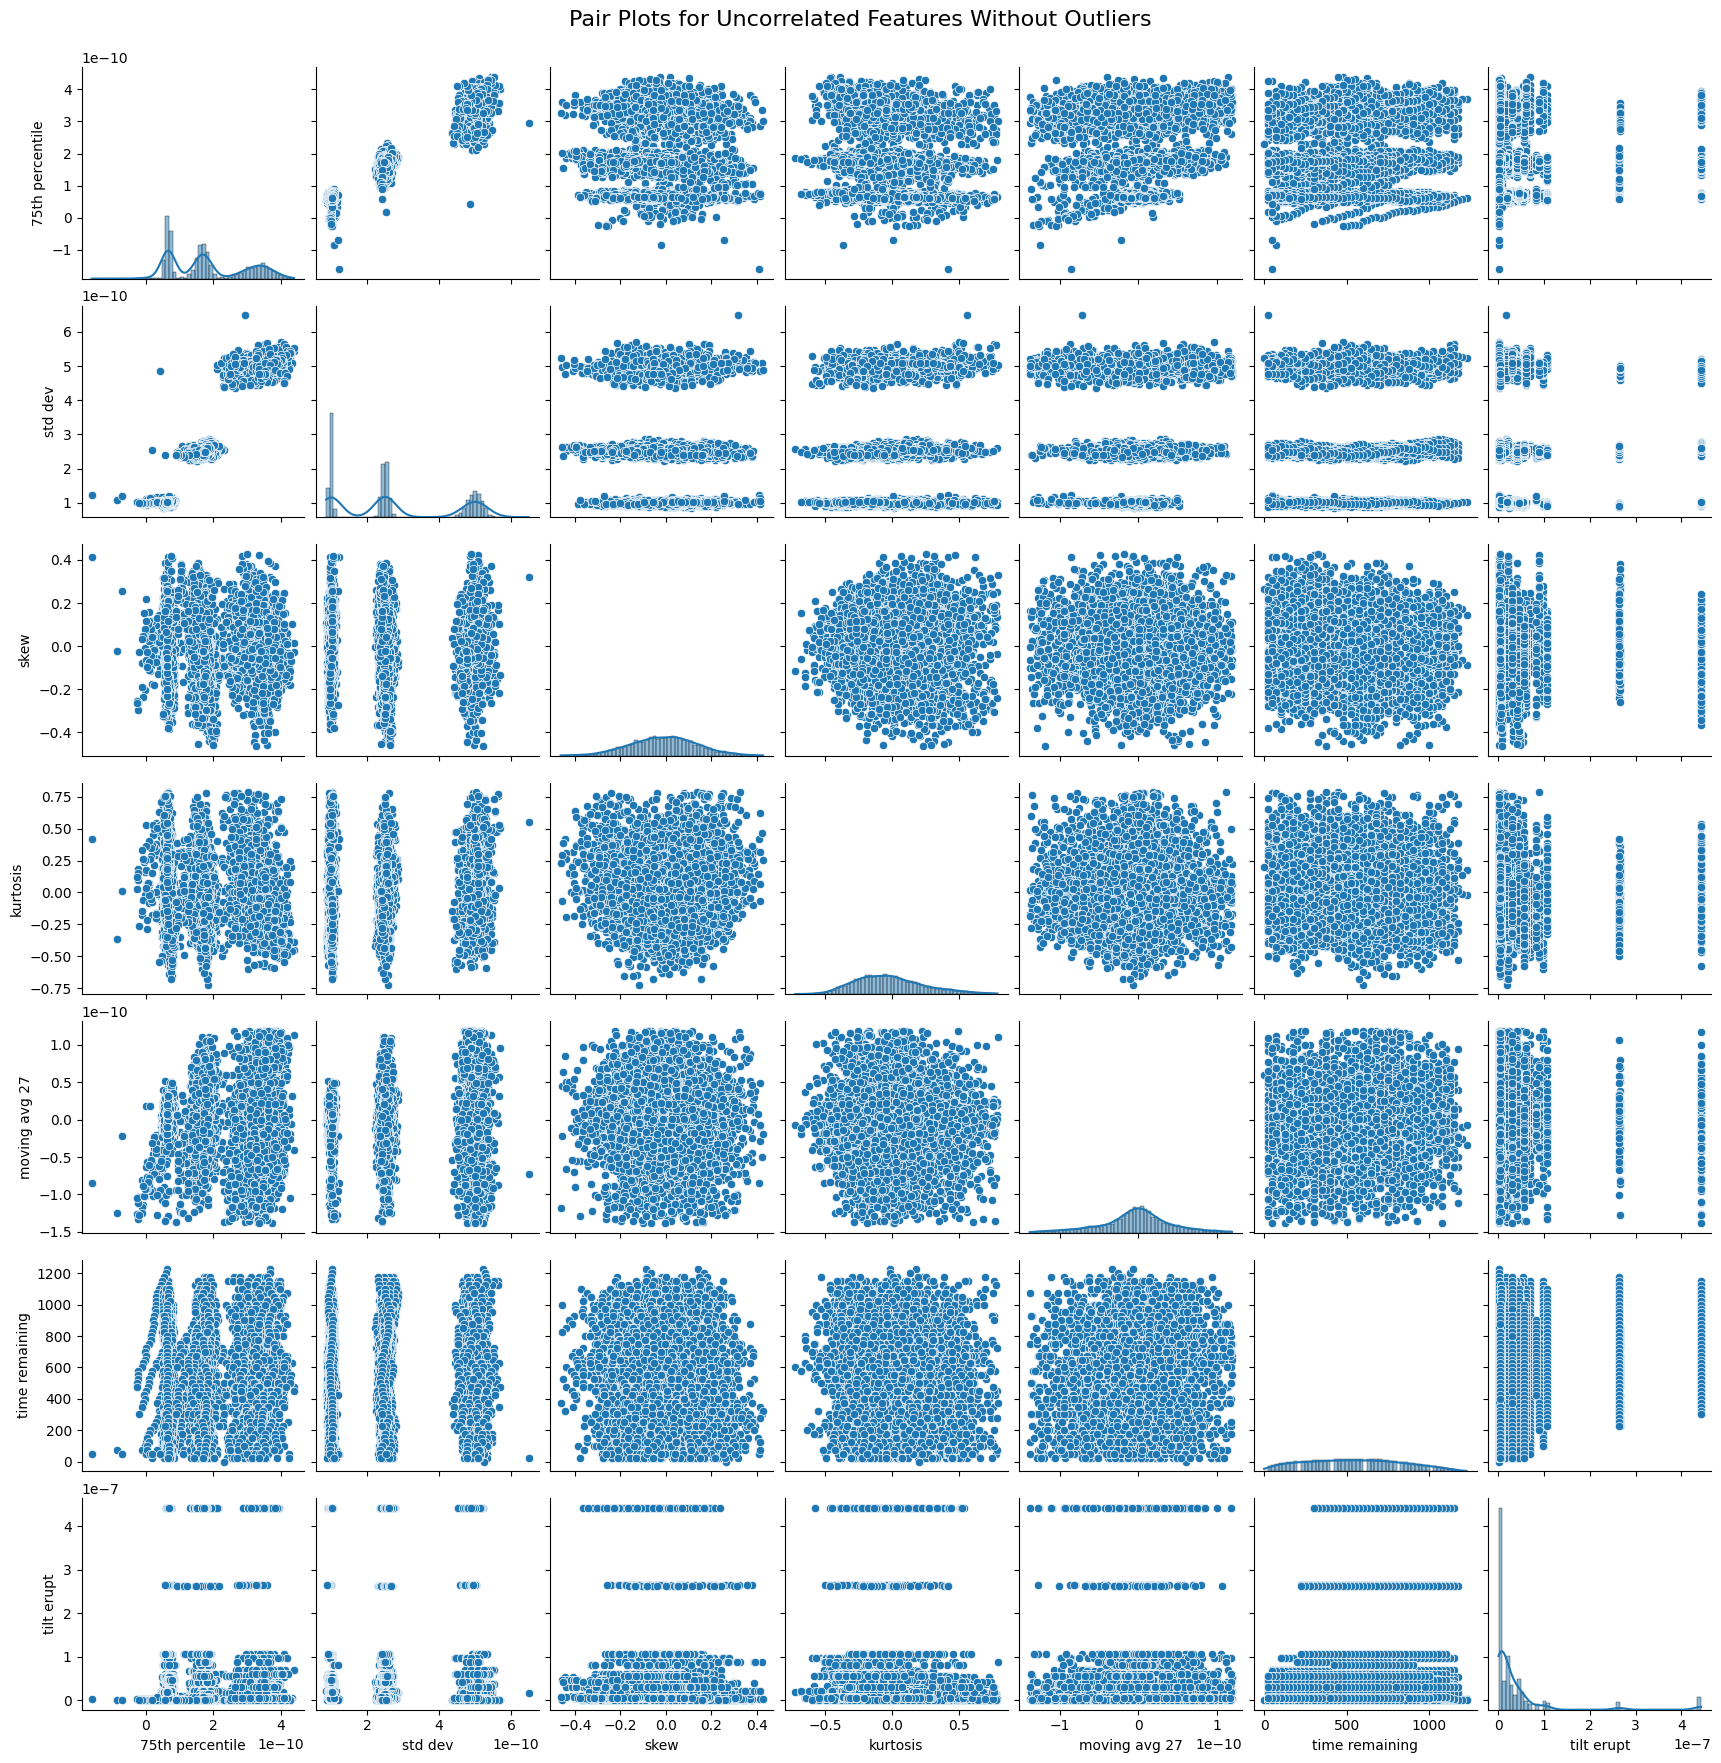

In [75]:
g = sns.pairplot(df_filtered1, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots for Uncorrelated Features Without Outliers', y=1.01, fontsize=16)

#### Better Option: Power Transformer

Usually we use linear scalers in our machine learning tasks, but there are non-linear options. The scikit-learn's PowerTransformer uses the Yeo-Johnson transform by default, which is a non-linear transformation that brings the outliers closer to the mean. We can see such an effect on some of the features in the two plots below. We also see peaks in the max, kurtosis, and mvoing avg 1 data shifted more towards the center of their ranges. I explore the effect of this transform on the modeling later on.

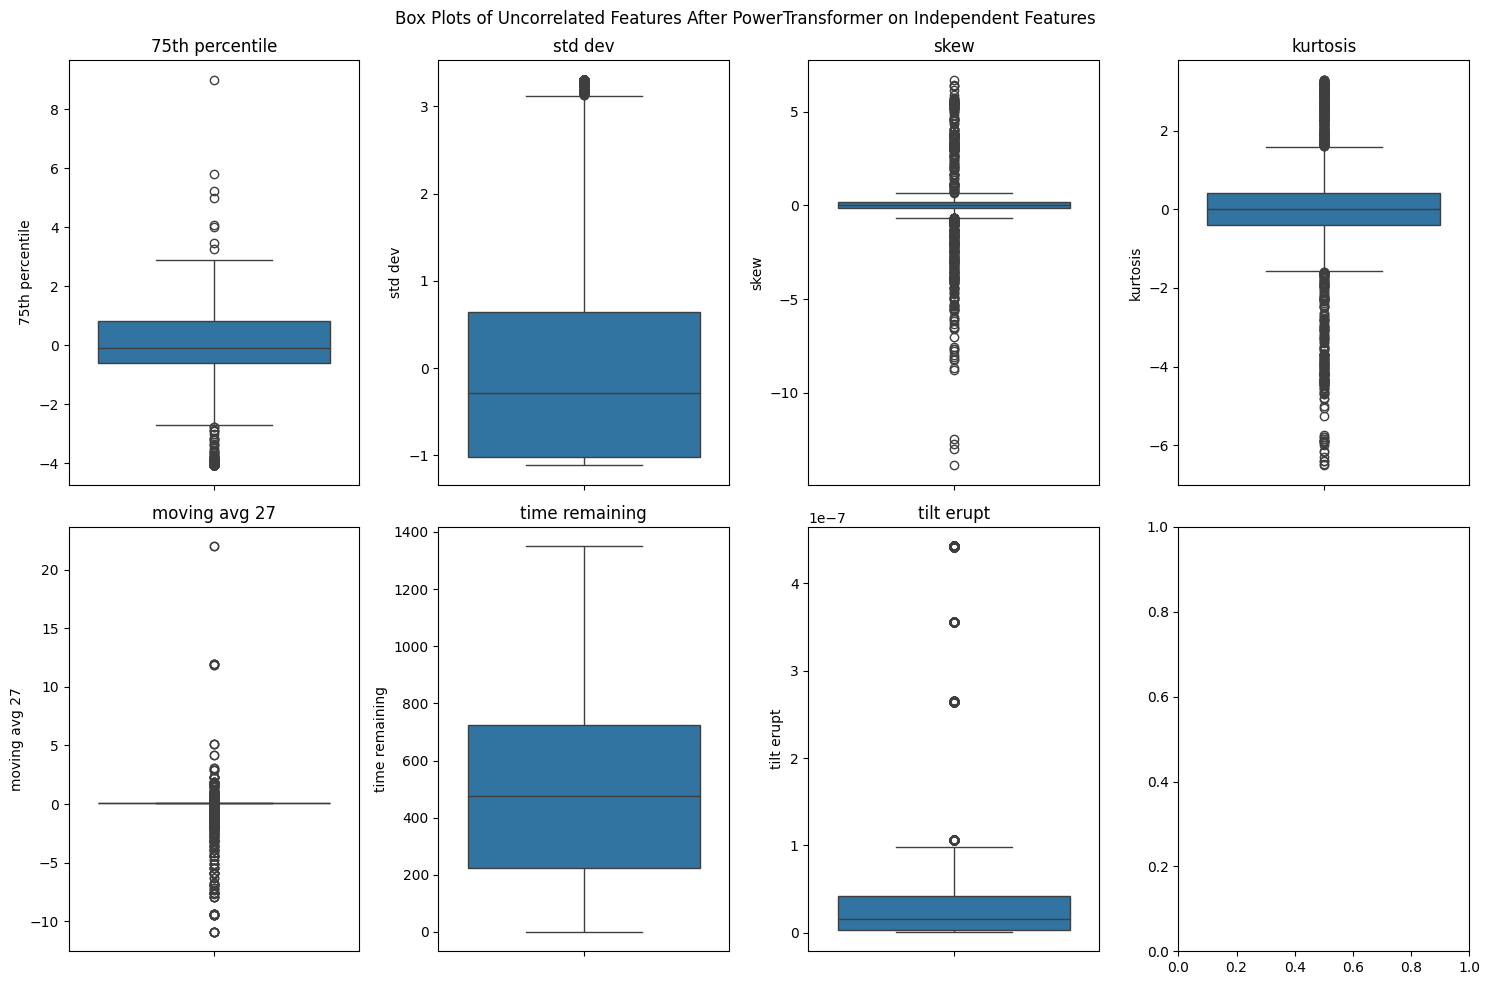

In [70]:
scaler = PowerTransformer()
X_train = df_uncorrelated.drop(columns=['time remaining', 'tilt erupt'])
X_transformed = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
df_tranformed = pd.concat([X_transformed, df_uncorrelated[['time remaining', 'tilt erupt']]], axis=1)
feature_box_plots(df_tranformed, cols=4, title='Box Plots of Uncorrelated Features After PowerTransformer on Independent Features')

Text(0.5, 1.01, 'Pair Plots of Uncorrelated Features After PowerTransformer on Independent Features')

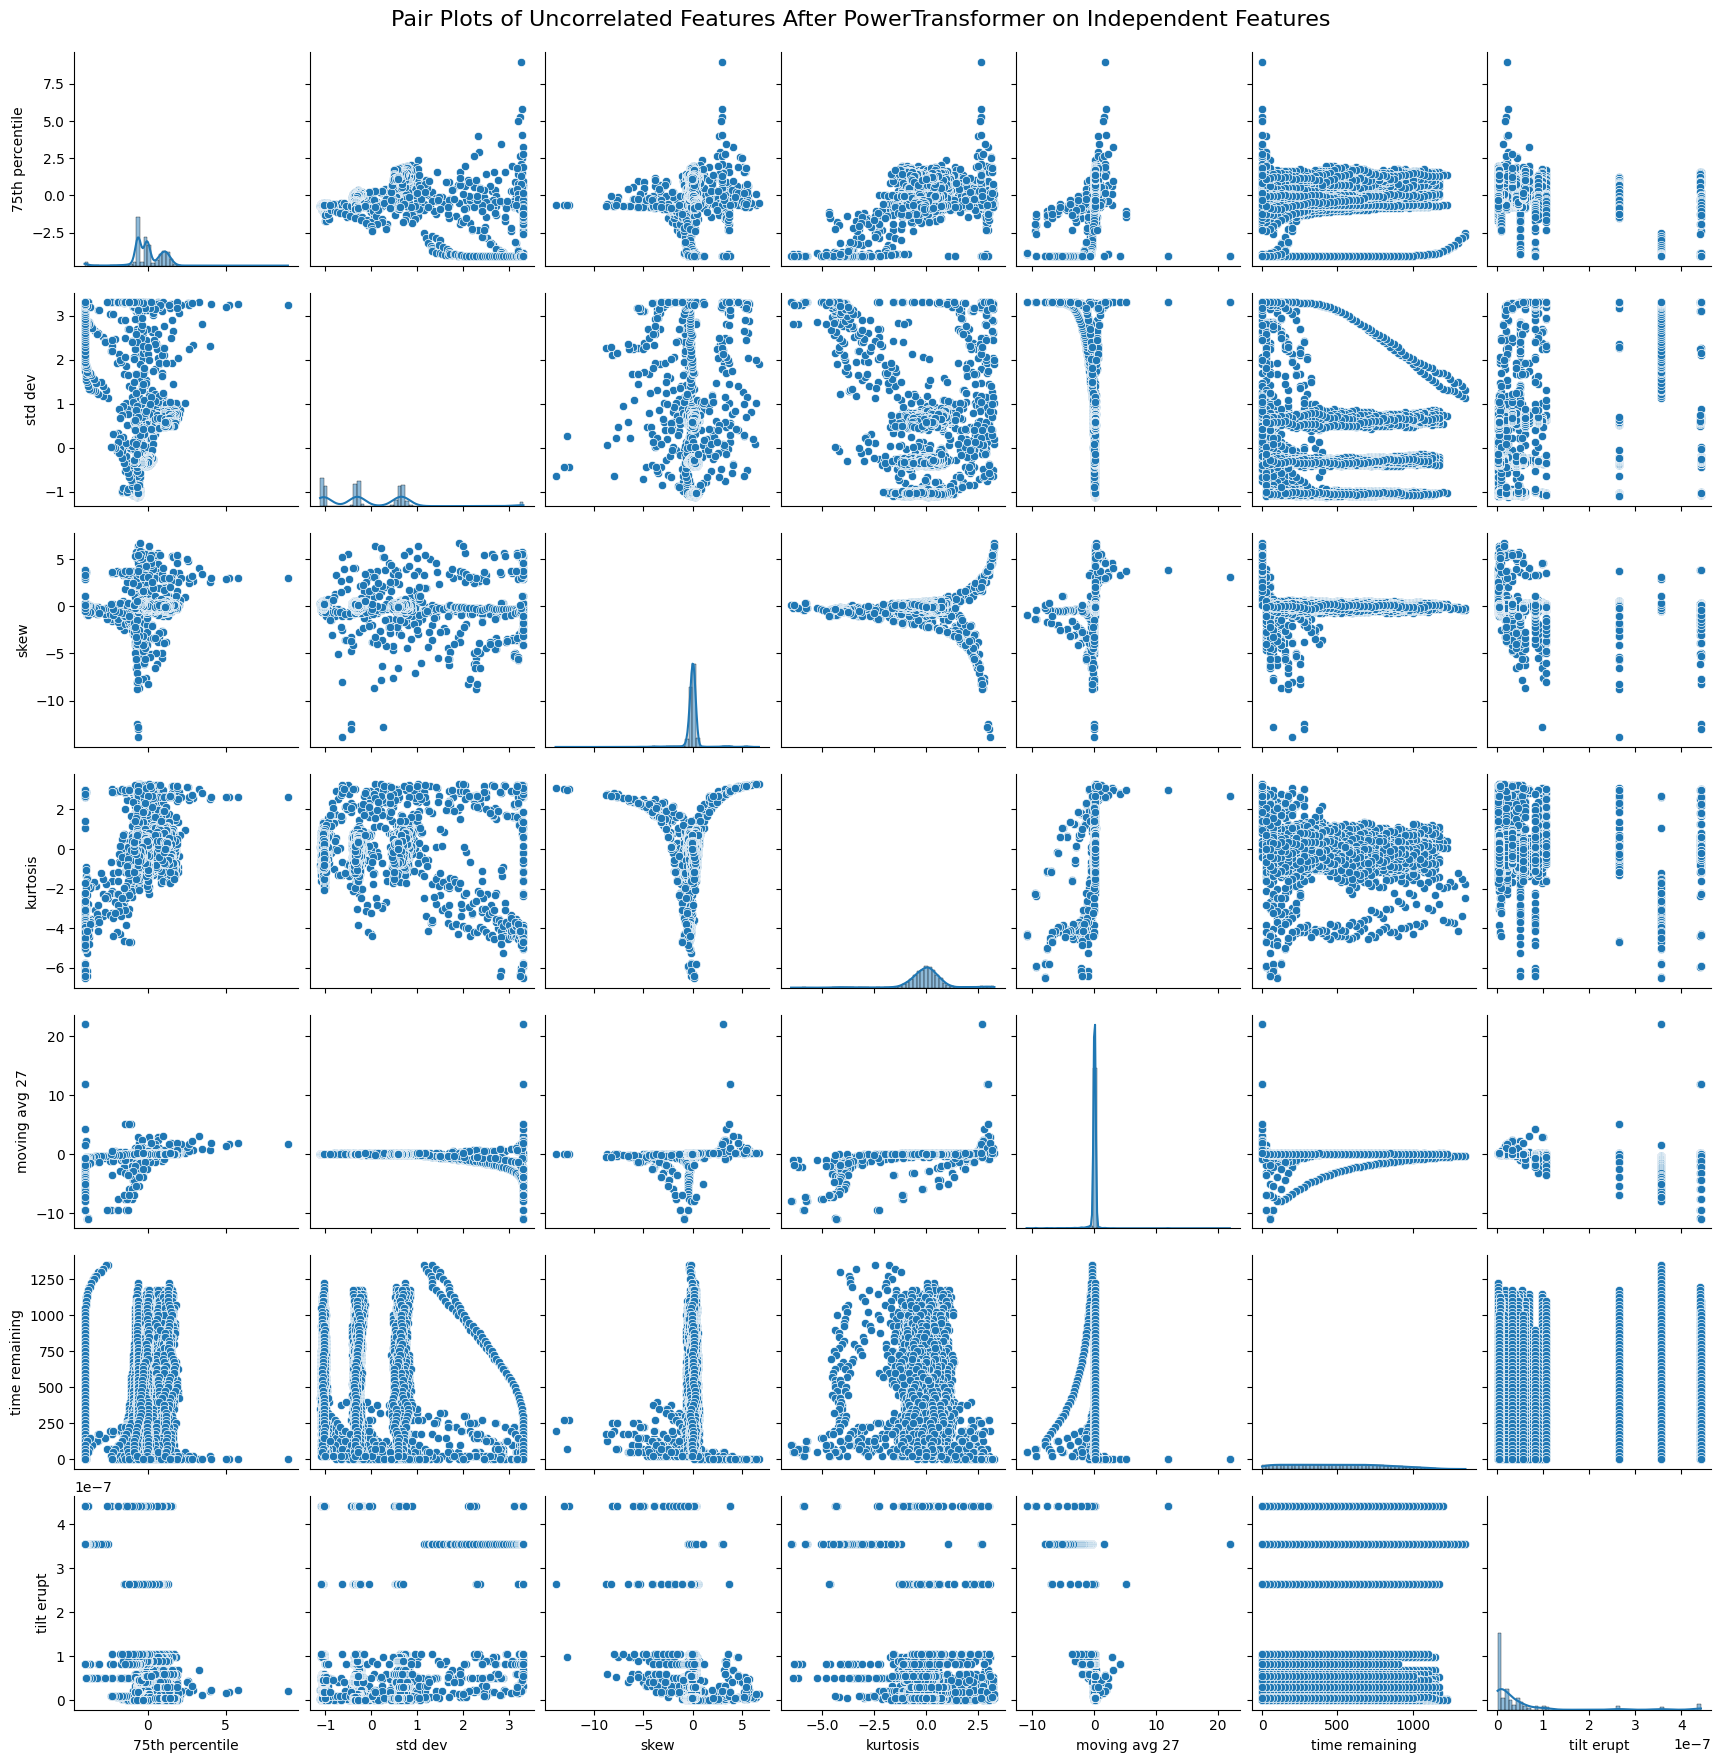

In [157]:
g = sns.pairplot(df_tranformed, diag_kws=dict(kde=True, bins=n_bins))
g.figure.suptitle('Pair Plots of Uncorrelated Features After PowerTransformer on Independent Features', y=1.01, fontsize=16)

## Model Testing: Use LazyPredict to test some feature engineering options

Setup a LazyPredict wrapper that does a train & test split, scales the data, and runs LazyPredict. We use this a lot, so it saves a lot of space.

Note that this function also scales/transforms the data and (optionally) performs a power tranfromation on y (can be used for the tilt erupt data).

In [24]:
def run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=PowerTransformer, transform_y=False):
    if scaler is not None:
        X_scaler = scaler()
        X_train_working = X_scaler.fit_transform(X_train)
        X_valitade_working = X_scaler.transform(X_validate)
    else:
        X_train_working = X_train
        X_valitade_working = X_validate
    
    if transform_y:
        y_scaler = scaler()
        y_train_working = y_scaler.fit_transform(y_train)
        y_validate_working = y_scaler.transform(y_validate)
    else:
        y_train_working = y_train
        y_validate_working = y_validate
        
    regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
    return regressor.fit(X_train_working, X_valitade_working, y_train_working, y_validate_working)

We need to determine the best sequence length to use, so I lay out which ones to test here. I could test longer sequence lengths, and it would improve some model results. However, I need to make a judgement call, and I choose a maximum sequence length of 300. Clearly, a sequence length of the entire observation sequence would produce a great result every time. However, it would also not produce a useful model. In practice (ignoring the fact that volcanologists don't directly measure pressure), we presumably have measurements coming in continuously, and run the model every few time-steps (or maybe every time-step if it's fast enough) to update the predictions. The longer the required time sequence for prediction, the longer we have to gather data before running the model. Therefore, I need to balance the fact that longer sequences produce better evaluation metrics with the wait time to start running the model. Without a domain exert to contribute, I have to make that call myself, and I choose 300 as the longest sequence.

In [159]:
test_seq_lens = [50, 100, 150, 200, 250, 300]

#### RMS Error Upper Bound by Predicting Mean

Set an upper bound on the root mean squared (RMS) error for our models by using the mean as the prediction (R^2 is by definition 0 for this prediction). I use the overlapped sequences for this calculation, but explore modeling the other options later with LazyPredict.

In [80]:
def RMSE_lower_bound(y_train, y_validate):
    return np.sqrt(np.sum((y_validate - np.mean(y_train))**2)/len(y_validate))

<u>Time to eruption</u>

In [164]:
for seq_len in test_seq_lens:
    df_train = extract_manual_features(*convert_series_to_sequences(data_train, seq_len=seq_len, type='overlap'))
    df_validate = extract_manual_features(*convert_series_to_sequences(data_validate, seq_len=seq_len, type='overlap'))
    RMSE_time = RMSE_lower_bound(df_train['time remaining'], df_validate['time remaining'])
    print(f'seq_len: {seq_len}, upper bound RMSE time to erupt: {RMSE_time:.2f}')

seq_len: 50, upper bound RMSE time to erupt: 374.58
seq_len: 100, upper bound RMSE time to erupt: 360.91
seq_len: 150, upper bound RMSE time to erupt: 347.30
seq_len: 200, upper bound RMSE time to erupt: 333.76
seq_len: 250, upper bound RMSE time to erupt: 320.29
seq_len: 300, upper bound RMSE time to erupt: 306.91


<u>Tilt erupt</u>

In [165]:
for seq_len in test_seq_lens:
    df_train = extract_manual_features(*convert_series_to_sequences(data_train, seq_len=seq_len, type='overlap'))
    df_validate = extract_manual_features(*convert_series_to_sequences(data_validate, seq_len=seq_len, type='overlap'))
    RMSE_tilt_erupt = RMSE_lower_bound(df_train['tilt erupt'], df_validate['tilt erupt'])
    print(f'seq_len: {seq_len}, upper bound RMSE tilt erupt: {RMSE_tilt_erupt:.2E}')

seq_len: 50, upper bound RMSE tilt erupt: 9.31E-08
seq_len: 100, upper bound RMSE tilt erupt: 9.32E-08
seq_len: 150, upper bound RMSE tilt erupt: 9.32E-08
seq_len: 200, upper bound RMSE tilt erupt: 9.32E-08
seq_len: 250, upper bound RMSE tilt erupt: 9.33E-08
seq_len: 300, upper bound RMSE tilt erupt: 9.33E-08


### Model Sequence Length Simulations with Manual Features
Simulations using manual feature extraction without handling multicollinearity or outliers/transformation. I use these to help determine which sequence extraction method and length work best for the time to eruption and the tilt erupt simulations.

In the end, my best option is to use overlapping sequences. Since that may take too long to run, my second best option is to use random training sequences with overlapping validation sequences.

Automate looping over sequence lengths

In [151]:
def seq_len_models_loop(lengths: list, df_function: callable, data_train: list, data_validate: list, extract_type_train: str, extract_type_validate: str, y_feature: str):
    best_models = []
    for seq_len in lengths:
        df_train = df_function(data_train, seq_len, extract_type_train, random_seed=5)
        df_validate = df_function(data_validate, seq_len, extract_type_validate, random_seed=6)
        X_train = df_train.drop(columns=['time remaining', 'tilt erupt'])
        X_validate = df_validate.drop(columns=['time remaining', 'tilt erupt'])
        y_train = df_train[y_feature]
        y_validate = df_validate[y_feature]
        models_time0, predictions_time0 = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None)
        top_model = models_time0.loc[models_time0['R-Squared'].idxmax()]
        top_model['Sequence Length'] = seq_len
        best_models.append(top_model.to_frame().T)

    best_models_frame = pd.concat(best_models)
    best_models_frame['Sequence Length'] = best_models_frame['Sequence Length'].astype('int32')
    best_models_frame.index.name = 'Model'
    best_models_frame.reset_index(inplace=True)
    best_models_frame.set_index('Sequence Length', inplace=True)
    return best_models_frame

#### Overlapping Training and Validation Sequences
While I test this option, I do not consider it a good one moving forward. Whether or not it is good from a theoretical standpoint, it takes a long time to run, so hyperparameter tuning would take too long if I can't improve to runtime via feauture selection and transformation.

<u>Time to Eruption</u>

The best sequence length by the R^2 metric, and secondarily the RMS error, is 300. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.20 and an RMS error of 274.

In [162]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='time remaining')

 98%|█████████▊| 41/42 [01:47<00:03,  3.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 6755, number of used features: 16
[LightGBM] [Info] Start training from score 617.646188


 98%|█████████▊| 41/42 [01:58<00:03,  3.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 6483, number of used features: 21
[LightGBM] [Info] Start training from score 593.035632


 98%|█████████▊| 41/42 [02:11<00:03,  3.81s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 6211, number of used features: 26
[LightGBM] [Info] Start training from score 568.459185


 98%|█████████▊| 41/42 [02:18<00:03,  3.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 5939, number of used features: 31
[LightGBM] [Info] Start training from score 543.921536


 98%|█████████▊| 41/42 [02:24<00:04,  4.89s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 5667, number of used features: 36
[LightGBM] [Info] Start training from score 519.428269


 98%|█████████▊| 41/42 [02:29<00:04,  4.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 5395, number of used features: 41
[LightGBM] [Info] Start training from score 494.986098


100%|██████████| 42/42 [02:29<00:00,  3.56s/it]


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50                        PoissonRegressor                0.07       0.08   
100                      AdaBoostRegressor                0.13       0.14   
150              GradientBoostingRegressor                0.15       0.17   
200                    ExtraTreesRegressor                0.17       0.18   
250                    ExtraTreesRegressor                0.18       0.20   
300                    ExtraTreesRegressor                0.18       0.20   

                   RMSE  Time Taken  
Sequence Length                      
50               360.00        0.07  
100              335.12        0.84  
150              316.59       14.41  
200              301.60       12.73  
250              287.02       13.92  
300              273.70       14.55

<u>Tilt Erupt</u>

The best sequence length by the R^2 metric, and secondarily the RMS error, is 300. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.57 and an RMS error of 6.09e-08.

In [163]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='overlap', extract_type_validate='overlap', y_feature='tilt erupt')

 98%|█████████▊| 41/42 [01:12<00:02,  2.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 6755, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [01:24<00:02,  2.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 6483, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [01:40<00:03,  3.10s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 6211, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [01:47<00:03,  3.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 5939, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


 95%|█████████▌| 40/42 [01:51<00:07,  3.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 5667, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


 95%|█████████▌| 40/42 [02:01<00:08,  4.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 5395, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [02:01<00:00,  2.90s/it]


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.38       0.38   
100              GradientBoostingRegressor                0.44       0.45   
150              GradientBoostingRegressor                0.50       0.51   
200                    ExtraTreesRegressor                0.53       0.54   
250                    ExtraTreesRegressor                0.55       0.57   
300                    ExtraTreesRegressor                0.56       0.57   

                     RMSE  Time Taken  
Sequence Length                        
50               7.32e-08        9.64  
100              6.91e-08       11.94  
150              6.55e-08       14.58  
200              6.35e-08        5.45  
250              6.15e-08        5.58  
300              6.09e-08        5.97

#### Sequential Training Sequences, Overlapping Validation Sequences
I do not consider sequential sequences to be a good option. The sequences are extracted at set positions that can be far apart, resulting in just a few discrete training values for the time to eruption. Therefore, tree models may not produce good results when trained on sequential sequences.

<u>Time to Eruption</u>

The best sequence length by the R^2 metric is 250. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.17 and an RMS error of 292.

In [166]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='overlap', y_feature='time remaining')

 98%|█████████▊| 41/42 [00:47<00:01,  1.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3415, number of used features: 16
[LightGBM] [Info] Start training from score 612.064422


 98%|█████████▊| 41/42 [00:29<00:00,  1.36it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 21
[LightGBM] [Info] Start training from score 573.983254


 98%|█████████▊| 41/42 [00:19<00:00,  1.96it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 26
[LightGBM] [Info] Start training from score 533.640553


 98%|█████████▊| 41/42 [00:15<00:00,  2.47it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 31
[LightGBM] [Info] Start training from score 504.584882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:15<00:00,  2.65it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



 98%|█████████▊| 41/42 [00:14<00:00,  2.95it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7505
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 36
[LightGBM] [Info] Start training from score 456.330128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:14<00:00,  2.90it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


 95%|█████████▌| 40/42 [00:11<00:00,  3.72it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6824
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 41
[LightGBM] [Info] Start training from score 410.240964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:12<00:00,  3.45it/s]


Model  Adjusted R-Squared  R-Squared    RMSE  \
Sequence Length                                                               
50                 AdaBoostRegressor                0.10       0.10  354.59   
100              ExtraTreesRegressor                0.09       0.11  341.31   
150              ExtraTreesRegressor                0.12       0.14  322.31   
200              ExtraTreesRegressor                0.11       0.13  311.23   
250              ExtraTreesRegressor                0.15       0.17  292.01   
300              ExtraTreesRegressor                0.12       0.15  283.35   

                 Time Taken  
Sequence Length              
50                     0.41  
100                    2.46  
150                    1.63  
200                    1.24  
250                    0.94  
300                    0.75

<u>Tilt Erupt</u>

The best sequence length by the R^2 metric, and secondarily the RMS error, is 150. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.44 and an RMS error of 6.98e-08.

In [167]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='overlap', y_feature='tilt erupt')

 93%|█████████▎| 39/42 [00:34<00:03,  1.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3415, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


 95%|█████████▌| 40/42 [00:19<00:01,  1.71it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:16<00:00,  2.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:15<00:00,  2.65it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

 98%|█████████▊| 41/42 [00:14<00:00,  2.89it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7505
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 42/42 [00:14<00:00,  2.85it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


 98%|█████████▊| 41/42 [00:12<00:00,  3.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6824
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 42/42 [00:12<00:00,  3.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.37       0.38   
100              GradientBoostingRegressor                0.40       0.41   
150                    ExtraTreesRegressor                0.43       0.44   
200                    ExtraTreesRegressor                0.42       0.44   
250                    ExtraTreesRegressor                0.42       0.44   
300                    ExtraTreesRegressor                0.36       0.38   

                     RMSE  Time Taken  
Sequence Length                        
50               7.36e-08        5.07  
100              7.17e-08        3.17  
150              6.98e-08        0.95  
200              7.00e-08        0.83  
250              7.00e-08        0.82  
300              7.34e-08        0.66

#### Sequential Training and Validation Sequences
I run these options together to illustrate the problem with using sequential sequences. The effect of using sequential sequences for both training and validation is huge, particularly on the R^2 metric for time to eruption. A jump from 0.20 for overlapping training and validation sequences to 0.60 for sequential ones indicates a serious problem.

<u>Time to Eruption</u>

The best sequence length by the R^2 metric is 300. The best model for that length is the AdaBoostRegressor with an R^2 score of 0.60 and an RMS error of 210.

In [172]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='sequential', y_feature='time remaining')

 98%|█████████▊| 41/42 [00:53<00:01,  1.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3415, number of used features: 16
[LightGBM] [Info] Start training from score 612.064422


 98%|█████████▊| 41/42 [00:34<00:00,  1.06it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 21
[LightGBM] [Info] Start training from score 573.983254


 98%|█████████▊| 41/42 [00:21<00:00,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 26
[LightGBM] [Info] Start training from score 533.640553


 95%|█████████▌| 40/42 [00:17<00:00,  2.23it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 31
[LightGBM] [Info] Start training from score 504.584882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:18<00:00,  2.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



 98%|█████████▊| 41/42 [00:16<00:00,  2.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7505
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 36
[LightGBM] [Info] Start training from score 456.330128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

 98%|█████████▊| 41/42 [00:14<00:00,  2.98it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6824
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 41
[LightGBM] [Info] Start training from score 410.240964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

100%|██████████| 42/42 [00:14<00:00,  2.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model  Adjusted R-Squared  R-Squared    RMSE  \
Sequence Length                                                                 
50                   AdaBoostRegressor                0.12       0.14  350.80   
100                ExtraTreesRegressor                0.18       0.22  327.46   
150              RandomForestRegressor                0.24       0.31  303.15   
200                ExtraTreesRegressor                0.29       0.40  275.21   
250              RandomForestRegressor                0.38       0.52  235.95   
300                  AdaBoostRegressor                0.40       0.60  209.53   

                 Time Taken  
Sequence Length              
50                     0.46  
100                    2.54  
150                    7.12  
200                    1.24  
250                    4.06  
300                    0.77

<u>Tilt Erupt</u>

The best sequence length by the R^2 metric is 250. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.61 and an RMS error of 5.88e-08.

In [173]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='sequential', extract_type_validate='sequential', y_feature='tilt erupt')

 98%|█████████▊| 41/42 [00:39<00:01,  1.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 3415, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


 95%|█████████▌| 40/42 [00:23<00:01,  1.46it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1672, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:18<00:00,  2.12it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:15<00:00,  2.49it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 807, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 42/42 [00:16<00:00,  2.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



 93%|█████████▎| 39/42 [00:15<00:01,  2.30it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7505
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 42/42 [00:16<00:00,  2.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



 98%|█████████▊| 41/42 [00:17<00:00,  3.21it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6824
[LightGBM] [Info] Number of data points in the train set: 498, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 42/42 [00:17<00:00,  2.34it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.38       0.39   
100              GradientBoostingRegressor                0.43       0.46   
150                    ExtraTreesRegressor                0.42       0.47   
200                    ExtraTreesRegressor                0.45       0.54   
250                    ExtraTreesRegressor                0.49       0.61   
300                    ExtraTreesRegressor                0.24       0.49   

                     RMSE  Time Taken  
Sequence Length                        
50               7.28e-08        5.50  
100              6.79e-08        4.76  
150              6.90e-08        1.03  
200              6.40e-08        0.87  
250              5.88e-08        0.83  
300              6.65e-08        1.37

#### Random Training Sequences, Overlapping Validation Sequences
I consider random training sequences to be the best option. It balances providing a good spread of training values for the time to eruption with a decent run-time. It will be a good option if I can't use overlapping training sequences.

<u>Time to Eruption</u>

The best sequence length by the R^2 metric is 250. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.18 and an RMS error of 289.

In [168]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='overlap', y_feature='time remaining')

 98%|█████████▊| 41/42 [00:28<00:00,  1.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 16
[LightGBM] [Info] Start training from score 634.851320


 98%|█████████▊| 41/42 [00:29<00:00,  1.25it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 21
[LightGBM] [Info] Start training from score 610.381745


 98%|█████████▊| 41/42 [00:32<00:00,  1.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 26
[LightGBM] [Info] Start training from score 581.997704


 98%|█████████▊| 41/42 [00:38<00:01,  1.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 31
[LightGBM] [Info] Start training from score 563.635476


 98%|█████████▊| 41/42 [00:42<00:01,  1.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 36
[LightGBM] [Info] Start training from score 530.913892


 98%|█████████▊| 41/42 [00:49<00:01,  1.38s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 41
[LightGBM] [Info] Start training from score 507.397819


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


Model  Adjusted R-Squared  R-Squared    RMSE  \
Sequence Length                                                                 
50                   AdaBoostRegressor                0.07       0.08  359.48   
100              RandomForestRegressor                0.05       0.07  348.53   
150                  AdaBoostRegressor                0.11       0.12  325.66   
200                ExtraTreesRegressor                0.12       0.14  310.09   
250                ExtraTreesRegressor                0.16       0.18  289.38   
300                  AdaBoostRegressor                0.14       0.16  280.60   

                 Time Taken  
Sequence Length              
50                     0.57  
100                   10.97  
150                    0.63  
200                    4.02  
250                    4.57  
300                    0.81

<u>Tilt Erupt</u>

The best sequence length by the R^2 metric is 300, but not by much. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.49 and an RMS error of 6.70e-08. 

In [169]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='overlap', y_feature='tilt erupt')

 93%|█████████▎| 39/42 [00:19<00:01,  1.56it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


 93%|█████████▎| 39/42 [00:23<00:02,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:29<00:00,  1.31it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:33<00:01,  1.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:39<00:01,  1.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:41<00:01,  1.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [00:42<00:00,  1.01s/it]


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50               GradientBoostingRegressor                0.30       0.30   
100                    ExtraTreesRegressor                0.34       0.35   
150                    ExtraTreesRegressor                0.41       0.42   
200                    ExtraTreesRegressor                0.46       0.47   
250                    ExtraTreesRegressor                0.47       0.48   
300                    ExtraTreesRegressor                0.47       0.49   

                     RMSE  Time Taken  
Sequence Length                        
50               7.77e-08        2.89  
100              7.52e-08        1.41  
150              7.12e-08        1.85  
200              6.78e-08        1.91  
250              6.71e-08        2.00  
300              6.70e-08        2.16

#### Random Training and Validation Sequences
I run this option to see if it has much impact on the validation scores. It does not. Since sequenctial validation sequences provide better data coverage, I will move forward with that option if I go with random training sequences.

<u>Time to Eruption</u>

The best sequence length by the R^2 metric is 250. The best model for that length is the GradientBoostingRegressor with an R^2 score of 0.20 and an RMS error of 280.

In [170]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='random', y_feature='time remaining')

 98%|█████████▊| 41/42 [00:27<00:00,  1.44it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 16
[LightGBM] [Info] Start training from score 634.851320


 98%|█████████▊| 41/42 [00:31<00:00,  1.13it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 21
[LightGBM] [Info] Start training from score 610.381745


 98%|█████████▊| 41/42 [00:43<00:00,  1.05it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 26
[LightGBM] [Info] Start training from score 581.997704


 98%|█████████▊| 41/42 [00:43<00:01,  1.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 31
[LightGBM] [Info] Start training from score 563.635476


 98%|█████████▊| 41/42 [00:46<00:01,  1.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 36
[LightGBM] [Info] Start training from score 530.913892


 98%|█████████▊| 41/42 [00:51<00:01,  1.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 41
[LightGBM] [Info] Start training from score 507.397819


100%|██████████| 42/42 [00:52<00:00,  1.25s/it]


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50                       AdaBoostRegressor                0.03       0.07   
100                       PoissonRegressor                0.02       0.07   
150                    ExtraTreesRegressor                0.01       0.07   
200                  RandomForestRegressor                0.02       0.09   
250              GradientBoostingRegressor                0.12       0.20   
300                      AdaBoostRegressor                0.06       0.15   

                   RMSE  Time Taken  
Sequence Length                      
50               372.05        0.75  
100              356.38        0.09  
150              329.70        4.01  
200              319.55       17.01  
250              280.11        6.86  
300              283.51        0.87

<u>Tilt Erupt</u>

The best sequence length by the R^2 metric is 300, but not by much. The best model for that length is the ExtraTreesRegressor with an R^2 score of 0.48 and an RMS error of 6.78e-8.

In [171]:
def df_function(data, seq_len, extract_type, random_seed):
    return extract_manual_features(*convert_series_to_sequences(data, seq_len, extract_type, random_seed=random_seed))

seq_len_models_loop(test_seq_lens, df_function=df_function, data_train=data_train, data_validate=data_validate,
                    extract_type_train='random', extract_type_validate='random', y_feature='tilt erupt')

 93%|█████████▎| 39/42 [00:19<00:02,  1.39it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:24<00:00,  1.45it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:29<00:00,  1.27it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 26
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:33<00:00,  1.06it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7904
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 31
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:36<00:00,  1.01it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 36
[LightGBM] [Info] Start training from score 0.000000


 98%|█████████▊| 41/42 [00:39<00:01,  1.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 1742, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [00:40<00:00,  1.04it/s]


Model  Adjusted R-Squared  R-Squared  \
Sequence Length                                                             
50                            SGDRegressor                0.29       0.31   
100                          BayesianRidge                0.40       0.43   
150              GradientBoostingRegressor                0.35       0.39   
200                    ExtraTreesRegressor                0.40       0.44   
250                    ExtraTreesRegressor                0.42       0.47   
300                    ExtraTreesRegressor                0.43       0.48   

                     RMSE  Time Taken  
Sequence Length                        
50               7.81e-08        0.02  
100              7.12e-08        0.03  
150              7.37e-08        4.52  
200              7.03e-08        1.80  
250              6.85e-08        1.99  
300              6.78e-08        2.06

#### Final Selections
These are used below further feature engineering and the final modeling.

In [12]:
time_seq_len = 300
tilt_erupt_seq_len = 300
time_extract_type_train = 'overlap'
time_extract_type_validate = 'overlap'
tilt_erupt_extract_type_train = 'overlap'
tilt_erupt_extract_type_validate = 'overlap'


## TSFresh
TSFresh is a tool that extracts features from time-sequence data. It comes up with hundreds of features, many of which are probably useless to us and many of which are probably correlated.

We have to extract features for the time to eruption and the tilt erupt separately, as TSFresh comes up with separate features for them. Unfortunately, we are not able to extract features for training and validation separately (at least without more research).

I don't test different sequence lengths here because TSFresh produces a lot of features and I'm using overlapping sequences with a sequence length of 300, which will make the models take a long time to train.

### Tests on features without modification

Using features from TSFresh amazingly improves the models a lot.

<u>Time to eruption</u>

Using TSFresh features did much better than my manual features. The best model switches from the ExtraTreesRegressor with an R^2 score of 0.20 and an RMS error of 274 to the HistGradientBoostingRegressor with an R^2 score of 0.67 and an RMS error of 178. I will clearly use TSFresh features for simulating the time to eruption moving forward. I have to determine how to improve the training time.

In [60]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_time = extract_relevant_features(pressure_seqs, y_time, column_id='sequence id', column_sort='time', ml_task='regression')
X_train, X_validate, y_train, y_validate = train_test_split(X_tsfresh_time, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models


 98%|█████████▊| 41/42 [16:54<00:14, 14.92s/it] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83699
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 365
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [16:56<00:00, 24.21s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor            5.48e-01   6.71e-01  1.78e+02   
LGBMRegressor                            5.43e-01   6.67e-01  1.79e+02   
ExtraTreesRegressor                      5.40e-01   6.65e-01  1.79e+02   
XGBRegressor                             5.38e-01   6.64e-01  1.80e+02   
RandomForestRegressor                    4.35e-01   5.89e-01  1.99e+02   
KNeighborsRegressor                      3.52e-01   5.29e-01  2.13e+02   
BaggingRegressor                         3.15e-01   5.01e-01  2.19e+02   
GradientBoostingRegressor                1.90e-01   4.10e-01  2.38e+02   
MLPRegressor                             1.51e-01   3.82e-01  2.44e+02   
PoissonRegressor                         3.99e-02   3.01e-01  2.59e+02   
RidgeCV                                  2.55e-02   2.91e-01  2.61e+02   
Ridge                                    2.13e-02   2.88e-01  2.61e+02   
TransformedTargetRegressor               2.05e-02   2.87e-01  2.62e+02   
LinearRegression                         2.05e-02   2.87e-01  2.62e+02   
LassoCV                                  1.48e-02   2.83e-01  2.62e+02   
Lasso                                    3.67e-03   2.75e-01  2.64e+02   
BayesianRidge                           -2.69e-03   2.70e-01  2.65e+02   
LassoLars                               -8.97e-03   2.66e-01  2.65e+02   
LassoLarsCV                             -8.97e-03   2.66e-01  2.65e+02   
LassoLarsIC                             -9.04e-03   2.66e-01  2.65e+02   
HuberRegressor                          -2.40e-02   2.55e-01  2.67e+02   
ElasticNetCV                            -2.60e-02   2.53e-01  2.68e+02   
OrthogonalMatchingPursuit               -4.54e-02   2.39e-01  2.70e+02   
OrthogonalMatchingPursuitCV             -4.54e-02   2.39e-01  2.70e+02   
LinearSVR                               -5.72e-02   2.30e-01  2.72e+02   
ElasticNet                              -5.98e-02   2.29e-01  2.72e+02   
TweedieRegressor                        -7.61e-02   2.17e-01  2.74e+02   
AdaBoostRegressor                       -1.14e-01   1.89e-01  2.79e+02   
SVR                                     -2.23e-01   1.10e-01  2.92e+02   
NuSVR                                   -2.46e-01   9.34e-02  2.95e+02   
LarsCV                                  -2.52e-01   8.85e-02  2.96e+02   
PassiveAggressiveRegressor              -3.03e-01   5.19e-02  3.02e+02   
DecisionTreeRegressor                   -3.38e-01   2.62e-02  3.06e+02   
DummyRegressor                          -3.74e-01  -9.06e-05  3.10e+02   
ExtraTreeRegressor                      -4.13e-01  -2.88e-02  3.14e+02   
KernelRidge                             -3.55e+00  -2.31e+00  5.64e+02   
GaussianProcessRegressor                -3.84e+00  -2.52e+00  5.81e+02   
RANSACRegressor                         -4.47e+03  -3.25e+03  1.77e+04   
SGDRegressor                            -4.01e+18  -2.92e+18  5.29e+11   
Lars                                    -1.25e+23  -9.10e+22  9.34e+13   

                               Time Taken  
Model                                      
HistGradientBoostingRegressor       11.57  
LGBMRegressor                        2.12  
ExtraTreesRegressor                119.85  
XGBRegressor                         3.26  
RandomForestRegressor              495.17  
KNeighborsRegressor                  0.19  
BaggingRegressor                    49.12  
GradientBoostingRegressor          145.19  
MLPRegressor                        23.27  
PoissonRegressor                     0.34  
RidgeCV                              0.64  
Ridge                                0.16  
TransformedTargetRegressor           0.42  
LinearRegression                     0.47  
LassoCV                             11.71  
Lasso                                1.64  
BayesianRidge                        0.86  
LassoLars                            0.24  
LassoLarsCV                          1.09 

<u>Tilt erupt</u>

TSFresh again does much better than the manual features. The best model switches from the ExtraTreesRegressor with an R^2 score of 0.57 and an RMS error of 6.09e-08 to the LGBMRegressor with an R^2 score of 0.77 and an RMS error of 4.87e-8. I will clearly be using the TSFresh features for modeling the tilt erupt moving forward. Again, I need to figure out how to improve the training time.

In [182]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')
X_train, X_validate, y_train, y_validate = train_test_split(X_tsfresh_tilt_erupt, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

 98%|█████████▊| 41/42 [44:28<00:47, 47.03s/it]   

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135037
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 566
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [44:32<00:00, 63.64s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
LGBMRegressor                            5.98e-01   7.68e-01  4.87e-08   
HistGradientBoostingRegressor            5.98e-01   7.68e-01  4.87e-08   
ExtraTreesRegressor                      4.51e-01   6.83e-01  5.69e-08   
GradientBoostingRegressor                1.59e-01   5.14e-01  7.04e-08   
RandomForestRegressor                    1.29e-01   4.96e-01  7.17e-08   
BaggingRegressor                         1.18e-01   4.90e-01  7.21e-08   
BayesianRidge                           -3.46e-02   4.02e-01  7.81e-08   
Ridge                                   -4.38e-02   3.96e-01  7.85e-08   
RidgeCV                                 -4.38e-02   3.96e-01  7.85e-08   
LassoCV                                 -5.81e-02   3.88e-01  7.90e-08   
ElasticNetCV                            -5.81e-02   3.88e-01  7.90e-08   
KNeighborsRegressor                     -9.05e-02   3.69e-01  8.02e-08   
LinearRegression                        -9.70e-02   3.65e-01  8.05e-08   
TransformedTargetRegressor              -9.70e-02   3.65e-01  8.05e-08   
OrthogonalMatchingPursuit               -1.60e-01   3.29e-01  8.28e-08   
OrthogonalMatchingPursuitCV             -1.65e-01   3.26e-01  8.29e-08   
GammaRegressor                          -3.21e-01   2.36e-01  8.83e-08   
KernelRidge                             -4.31e-01   1.72e-01  9.19e-08   
ExtraTreeRegressor                      -4.71e-01   1.49e-01  9.32e-08   
DecisionTreeRegressor                   -6.07e-01   7.06e-02  9.74e-08   
PoissonRegressor                        -7.34e-01  -2.81e-03  1.01e-07   
TweedieRegressor                        -7.34e-01  -2.81e-03  1.01e-07   
LassoLars                               -7.34e-01  -2.81e-03  1.01e-07   
LassoLarsIC                             -7.34e-01  -2.81e-03  1.01e-07   
Lasso                                   -7.34e-01  -2.81e-03  1.01e-07   
DummyRegressor                          -7.34e-01  -2.81e-03  1.01e-07   
ElasticNet                              -7.34e-01  -2.81e-03  1.01e-07   
LarsCV                                  -7.34e-01  -2.81e-03  1.01e-07   
Lars                                    -7.34e-01  -2.81e-03  1.01e-07   
LassoLarsCV                             -7.34e-01  -2.81e-03  1.01e-07   
XGBRegressor                            -7.34e-01  -2.81e-03  1.01e-07   
NuSVR                                   -1.17e+00  -2.55e-01  1.13e-07   
GaussianProcessRegressor                -1.18e+00  -2.64e-01  1.14e-07   
PassiveAggressiveRegressor              -1.18e+00  -2.64e-01  1.14e-07   
AdaBoostRegressor                       -1.19e+00  -2.66e-01  1.14e-07   
LinearSVR                               -2.35e+00  -9.41e-01  1.41e-07   
SVR                                     -5.62e+00  -2.83e+00  1.98e-07   
HuberRegressor                          -8.40e+02  -4.85e+02  2.23e-06   
RANSACRegressor                         -4.38e+07  -2.53e+07  5.08e-04   
MLPRegressor                            -4.05e+12  -2.34e+12  1.55e-01   
SGDRegressor                            -1.71e+37  -9.90e+36  3.18e+11   

                               Time Taken  
Model                                      
LGBMRegressor                        4.00  
HistGradientBoostingRegressor       15.82  
ExtraTreesRegressor                 89.39  
GradientBoostingRegressor          258.67  
RandomForestRegressor             1845.08  
BaggingRegressor                   188.79  
BayesianRidge                        1.08  
Ridge                                0.29  
RidgeCV                              1.33  
LassoCV                             20.62  
ElasticNetCV                        20.93  
KNeighborsRegressor                  0.28  
LinearRegression                     0.84  
TransformedTargetRegressor           1.38  
OrthogonalMatchingPursuit            0.26  
OrthogonalMatchingPursuitCV          0.83  
GammaRegressor                       0.29  
KernelRidge 

### Dimensionality reduction via factor analysis

I can't do feature selection via variance inflation factors or condition indexes because iterating by removing a feature and re-calculating the metrics a few hundred times would take too long. Instead, I found that dimensionality reduction is a lot faster. Unfortunately, it doesn't work well and also makes the models much less explainable.

<u>Time to Eruption</u>

Three nines of the variation in the features is explained with just 30 components. Except that it doesn't work. Whereas before the best model was the HistGradientBoostingRegressor with an R^2 score of 0.67 and an RMS error of 178, here the best model is the ExtraTreesRegressor with an R^2 score of 0.22 and an RMS error of 274. PCA does worse, with the best model being the ExtraTreesRegressor with an R^2 score of 0.20 and an RMS error of 277 using 29 components.

In [15]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_time = extract_relevant_features(pressure_seqs, y_time, column_id='sequence id', column_sort='time', ml_task='regression')

Feature Extraction: 100%|██████████| 40/40 [03:20<00:00,  5.01s/it]


In [32]:
components_time_fa, prop_var_exp = factor_analysis_explained(X_tsfresh_time, 30)
print(f'Variance explained by FA components: {prop_var_exp.round(3)}')
print(f'Cumulative proportion of variance explained by FA components: {np.cumsum(prop_var_exp).round(3)}')

Variance explained by FA components: [0.031 0.096 0.062 0.041 0.039 0.039 0.038 0.038 0.038 0.037 0.037 0.036
 0.036 0.036 0.036 0.035 0.035 0.034 0.034 0.034 0.034 0.033 0.032 0.032
 0.031 0.022 0.002 0.001 0.    0.   ]
Cumulative proportion of variance explained by FA components: [0.031 0.127 0.189 0.23  0.269 0.308 0.346 0.384 0.421 0.459 0.495 0.532
 0.568 0.603 0.639 0.674 0.709 0.743 0.777 0.811 0.844 0.877 0.909 0.942
 0.973 0.995 0.998 0.998 0.999 0.999]


In [37]:
X_train, X_validate, y_train, y_validate = train_test_split(components_time_fa, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [01:50<00:03,  3.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 30
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [01:51<00:00,  2.64s/it]


Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreesRegressor                      1.98e-01   2.16e-01  274.28   
RandomForestRegressor                    1.93e-01   2.11e-01  275.17   
LGBMRegressor                            1.81e-01   2.00e-01  277.08   
GradientBoostingRegressor                1.72e-01   1.90e-01  278.72   
MLPRegressor                             1.68e-01   1.86e-01  279.43   
HistGradientBoostingRegressor            1.67e-01   1.86e-01  279.48   
PoissonRegressor                         1.51e-01   1.70e-01  282.23   
BaggingRegressor                         1.49e-01   1.68e-01  282.50   
LassoCV                                  1.43e-01   1.62e-01  283.56   
LarsCV                                   1.43e-01   1.62e-01  283.56   
LassoLarsCV                              1.43e-01   1.62e-01  283.56   
LassoLarsIC                              1.43e-01   1.62e-01  283.57   
LassoLars                                1.42e-01   1.62e-01  283.61   
Lasso                                    1.42e-01   1.62e-01  283.61   
RidgeCV                                  1.41e-01   1.60e-01  283.79   
Ridge                                    1.41e-01   1.60e-01  283.80   
LinearRegression                         1.41e-01   1.60e-01  283.80   
Lars                                     1.41e-01   1.60e-01  283.80   
TransformedTargetRegressor               1.41e-01   1.60e-01  283.80   
BayesianRidge                            1.41e-01   1.60e-01  283.80   
ElasticNetCV                             1.41e-01   1.60e-01  283.89   
SGDRegressor                             1.40e-01   1.59e-01  284.03   
HuberRegressor                           1.37e-01   1.56e-01  284.49   
OrthogonalMatchingPursuitCV              1.30e-01   1.49e-01  285.69   
ElasticNet                               1.24e-01   1.43e-01  286.71   
AdaBoostRegressor                        1.15e-01   1.35e-01  288.05   
OrthogonalMatchingPursuit                1.06e-01   1.26e-01  289.58   
TweedieRegressor                         1.02e-01   1.22e-01  290.30   
LinearSVR                                9.43e-02   1.14e-01  291.47   
XGBRegressor                             6.07e-02   8.17e-02  296.82   
PassiveAggressiveRegressor               5.90e-02   8.00e-02  297.09   
SVR                                      2.03e-02   4.22e-02  303.13   
NuSVR                                    1.38e-02   3.58e-02  304.14   
KNeighborsRegressor                     -2.18e-03   2.02e-02  306.59   
DummyRegressor                          -2.29e-02  -9.06e-05  309.74   
DecisionTreeRegressor                   -5.44e-01  -5.10e-01  380.55   
ExtraTreeRegressor                      -5.79e-01  -5.44e-01  384.82   
RANSACRegressor                         -1.80e+00  -1.73e+00  512.08   
KernelRidge                             -2.47e+00  -2.40e+00  570.89   
GaussianProcessRegressor                -2.58e+00  -2.50e+00  579.81   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 10.50  
RandomForestRegressor               51.96  
LGBMRegressor                        0.45  
GradientBoostingRegressor           14.38  
MLPRegressor                        10.43  
HistGradientBoostingRegressor        2.49  
PoissonRegressor                     0.04  
BaggingRegressor                     5.32  
LassoCV                              0.13  
LarsCV                               0.08  
LassoLarsCV                          0.08  
LassoLarsIC                          0.04  
LassoLars                            0.03  
Lasso                                0.02  
RidgeCV                              0.04  
Ridge                                0.02  
LinearRegression                     0.03  
Lars                                 0.03  
TransformedTargetRegressor           0.02  
BayesianRidge                        0.04  
ElasticNetCV                         0

In [50]:
pca = PCA(n_components=29)
components_time_pca = pca.fit_transform(X_tsfresh_time)
print(f'Variance explained by first PCA component: {pca.explained_variance_ratio_.round(3)}')
print(f'Cumulative proportion of variance explained by PCA components: {np.cumsum(pca.explained_variance_ratio_).round(3)}')

Variance explained by first PCA component: [0.104 0.066 0.049 0.039 0.039 0.038 0.038 0.038 0.037 0.037 0.036 0.036
 0.036 0.036 0.035 0.035 0.034 0.034 0.034 0.033 0.033 0.032 0.032 0.031
 0.026 0.008 0.002 0.001 0.   ]
Cumulative proportion of variance explained by PCA components: [0.104 0.17  0.219 0.258 0.297 0.335 0.373 0.41  0.447 0.484 0.52  0.556
 0.592 0.628 0.663 0.698 0.732 0.766 0.8   0.833 0.866 0.899 0.931 0.962
 0.989 0.997 0.998 0.999 1.   ]


In [52]:
X_train, X_validate, y_train, y_validate = train_test_split(components_time_pca, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

 98%|█████████▊| 41/42 [01:51<00:03,  3.17s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 29
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [01:52<00:00,  2.67s/it]


Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreesRegressor                      1.85e-01   2.03e-01  276.52   
RandomForestRegressor                    1.83e-01   2.01e-01  276.94   
HistGradientBoostingRegressor            1.54e-01   1.73e-01  281.75   
GradientBoostingRegressor                1.53e-01   1.71e-01  282.04   
LGBMRegressor                            1.48e-01   1.67e-01  282.74   
MLPRegressor                             1.26e-01   1.45e-01  286.35   
BaggingRegressor                         1.24e-01   1.43e-01  286.68   
OrthogonalMatchingPursuitCV              1.12e-01   1.31e-01  288.68   
AdaBoostRegressor                        1.11e-01   1.30e-01  288.86   
LassoLarsIC                              1.09e-01   1.28e-01  289.26   
LarsCV                                   1.08e-01   1.28e-01  289.29   
LassoLarsCV                              1.08e-01   1.28e-01  289.29   
LassoCV                                  1.08e-01   1.28e-01  289.30   
Lasso                                    1.07e-01   1.26e-01  289.51   
LassoLars                                1.07e-01   1.26e-01  289.51   
BayesianRidge                            1.06e-01   1.25e-01  289.72   
ElasticNetCV                             1.06e-01   1.25e-01  289.73   
RidgeCV                                  1.06e-01   1.25e-01  289.74   
Ridge                                    1.06e-01   1.25e-01  289.74   
TransformedTargetRegressor               1.06e-01   1.25e-01  289.75   
LinearRegression                         1.06e-01   1.25e-01  289.75   
Lars                                     1.06e-01   1.25e-01  289.75   
PoissonRegressor                         1.03e-01   1.23e-01  290.10   
SGDRegressor                             1.02e-01   1.21e-01  290.38   
HuberRegressor                           1.00e-01   1.20e-01  290.62   
ElasticNet                               9.32e-02   1.13e-01  291.74   
OrthogonalMatchingPursuit                8.06e-02   1.00e-01  293.76   
TweedieRegressor                         7.59e-02   9.58e-02  294.52   
XGBRegressor                             6.48e-02   8.49e-02  296.29   
LinearSVR                                6.07e-02   8.10e-02  296.93   
PassiveAggressiveRegressor               2.06e-02   4.17e-02  303.21   
SVR                                      1.26e-02   3.38e-02  304.44   
NuSVR                                    6.79e-03   2.82e-02  305.33   
DummyRegressor                          -2.21e-02  -9.06e-05  309.74   
KNeighborsRegressor                     -3.56e-02  -1.33e-02  311.78   
DecisionTreeRegressor                   -5.47e-01  -5.13e-01  381.02   
ExtraTreeRegressor                      -5.79e-01  -5.45e-01  384.98   
KernelRidge                             -2.50e+00  -2.43e+00  573.49   
GaussianProcessRegressor                -2.58e+00  -2.51e+00  580.07   
RANSACRegressor                         -3.02e+00  -2.94e+00  614.50   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 10.27  
RandomForestRegressor               53.66  
HistGradientBoostingRegressor        2.18  
GradientBoostingRegressor           14.21  
LGBMRegressor                        0.53  
MLPRegressor                        10.99  
BaggingRegressor                     5.64  
OrthogonalMatchingPursuitCV          0.05  
AdaBoostRegressor                    1.37  
LassoLarsIC                          0.04  
LarsCV                               0.08  
LassoLarsCV                          0.08  
LassoCV                              0.14  
Lasso                                0.02  
LassoLars                            0.02  
BayesianRidge                        0.04  
ElasticNetCV                         0.13  
RidgeCV                              0.04  
Ridge                                0.02  
TransformedTargetRegressor           0.03  
LinearRegression                     0

<u>Tilt Erupt</u>

Three nines of the variation in the features is explained with just 41 components. Except that it also doesn't work. Whereas before the best model was the LGBMRegressor with an R^2 of 0.77 and an RMS error of 4.87e-8, now it's the ExtraTreesRegressor with an R^2 score of 0.28 and an RMS error of 8.55e-8. Principal component analysis does worse, with the best model being the ExtraTreesRegressor with an R^2 score of 0.28 and an RMS error of 8.59e-8 using 42 components.

In [23]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')

Feature Extraction: 100%|██████████| 40/40 [03:19<00:00,  4.98s/it]


In [40]:
components_tilt_erupt_fa, prop_var_exp = factor_analysis_explained(X_tsfresh_tilt_erupt, 41)
print(f'Variance explained by FA components: {prop_var_exp.round(3)}')
print(f'Cumulative proportion of variance explained by FA components: {np.cumsum(prop_var_exp).round(3)}')

Variance explained by FA components: [0.01  0.63  0.021 0.022 0.01  0.011 0.01  0.01  0.009 0.01  0.01  0.009
 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009
 0.009 0.008 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.008 0.006 0.001]
Cumulative proportion of variance explained by FA components: [0.01  0.641 0.662 0.684 0.694 0.704 0.714 0.724 0.733 0.743 0.753 0.762
 0.772 0.781 0.79  0.799 0.808 0.817 0.826 0.835 0.844 0.852 0.861 0.87
 0.878 0.887 0.895 0.904 0.912 0.921 0.929 0.937 0.945 0.953 0.961 0.969
 0.977 0.984 0.993 0.998 0.999]


In [41]:
X_train, X_validate, y_train, y_validate = train_test_split(components_tilt_erupt_fa, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [02:41<00:05,  5.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 41
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [02:42<00:00,  3.86s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      2.62e-01   2.84e-01  8.55e-08   
RandomForestRegressor                    2.42e-01   2.65e-01  8.66e-08   
GradientBoostingRegressor                2.39e-01   2.62e-01  8.68e-08   
LGBMRegressor                            2.22e-01   2.45e-01  8.77e-08   
HistGradientBoostingRegressor            2.17e-01   2.41e-01  8.80e-08   
ElasticNetCV                             1.67e-01   1.92e-01  9.08e-08   
LassoCV                                  1.67e-01   1.92e-01  9.08e-08   
RidgeCV                                  1.66e-01   1.91e-01  9.08e-08   
Ridge                                    1.66e-01   1.91e-01  9.08e-08   
BayesianRidge                            1.66e-01   1.91e-01  9.08e-08   
TransformedTargetRegressor               1.66e-01   1.91e-01  9.08e-08   
LinearRegression                         1.66e-01   1.91e-01  9.08e-08   
SGDRegressor                             1.61e-01   1.86e-01  9.11e-08   
OrthogonalMatchingPursuitCV              1.58e-01   1.84e-01  9.13e-08   
BaggingRegressor                         1.53e-01   1.79e-01  9.16e-08   
OrthogonalMatchingPursuit                1.52e-01   1.78e-01  9.16e-08   
GammaRegressor                           1.05e-01   1.32e-01  9.41e-08   
KNeighborsRegressor                      7.59e-02   1.04e-01  9.56e-08   
HuberRegressor                           7.58e-02   1.04e-01  9.56e-08   
GaussianProcessRegressor                 2.80e-02   5.76e-02  9.81e-08   
AdaBoostRegressor                        6.76e-03   3.70e-02  9.91e-08   
LassoLarsCV                             -3.43e-02  -2.81e-03  1.01e-07   
Lars                                    -3.43e-02  -2.81e-03  1.01e-07   
TweedieRegressor                        -3.43e-02  -2.81e-03  1.01e-07   
DummyRegressor                          -3.43e-02  -2.81e-03  1.01e-07   
ElasticNet                              -3.43e-02  -2.81e-03  1.01e-07   
LassoLarsIC                             -3.43e-02  -2.81e-03  1.01e-07   
PoissonRegressor                        -3.43e-02  -2.81e-03  1.01e-07   
LassoLars                               -3.43e-02  -2.81e-03  1.01e-07   
LarsCV                                  -3.43e-02  -2.81e-03  1.01e-07   
Lasso                                   -3.43e-02  -2.81e-03  1.01e-07   
XGBRegressor                            -3.43e-02  -2.81e-03  1.01e-07   
KernelRidge                             -7.83e-02  -4.54e-02  1.03e-07   
LinearSVR                               -2.80e-01  -2.41e-01  1.13e-07   
RANSACRegressor                         -2.83e-01  -2.44e-01  1.13e-07   
NuSVR                                   -2.95e-01  -2.55e-01  1.13e-07   
PassiveAggressiveRegressor              -3.03e-01  -2.64e-01  1.14e-07   
ExtraTreeRegressor                      -4.18e-01  -3.75e-01  1.18e-07   
DecisionTreeRegressor                   -6.57e-01  -6.07e-01  1.28e-07   
SVR                                     -2.95e+00  -2.83e+00  1.98e-07   
MLPRegressor                            -5.62e+11  -5.45e+11  7.46e-02   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  5.87  
RandomForestRegressor              108.59  
GradientBoostingRegressor           19.60  
LGBMRegressor                        0.54  
HistGradientBoostingRegressor        2.98  
ElasticNetCV                         0.15  
LassoCV                              0.16  
RidgeCV                              0.05  
Ridge                                0.02  
BayesianRidge                        0.05  
TransformedTargetRegressor           0.03  
LinearRegression                     0.05  
SGDRegressor                         0.03  
OrthogonalMatchingPursuitCV          0.06  
BaggingRegressor                    11.14  
OrthogonalMatchingPursuit            0.03  
GammaRegressor                       0.03  
KNeighborsRe

In [45]:
pca = PCA(n_components=42)
components_tilt_erupt_pca = pca.fit_transform(X_tsfresh_tilt_erupt)
print(f'Variance explained by first PCA component: {pca.explained_variance_ratio_.round(3)}')
print(f'Cumulative proportion of variance explained by PCA components: {np.cumsum(pca.explained_variance_ratio_).round(3)}')

Variance explained by first PCA component: [0.63  0.03  0.022 0.011 0.01  0.01  0.01  0.01  0.009 0.009 0.009 0.009
 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009
 0.009 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.006 0.002 0.001 0.   ]
Cumulative proportion of variance explained by PCA components: [0.63  0.66  0.682 0.693 0.703 0.713 0.723 0.732 0.742 0.751 0.761 0.77
 0.779 0.788 0.798 0.807 0.815 0.824 0.833 0.842 0.851 0.86  0.868 0.877
 0.885 0.894 0.902 0.911 0.919 0.927 0.936 0.944 0.952 0.96  0.967 0.975
 0.983 0.99  0.997 0.999 0.999 1.   ]


In [46]:
X_train, X_validate, y_train, y_validate = train_test_split(components_tilt_erupt_pca, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [02:49<00:06,  6.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 42
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [02:50<00:00,  4.05s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      2.53e-01   2.77e-01  8.59e-08   
GradientBoostingRegressor                2.34e-01   2.58e-01  8.70e-08   
RandomForestRegressor                    2.22e-01   2.47e-01  8.77e-08   
LGBMRegressor                            2.07e-01   2.32e-01  8.85e-08   
HistGradientBoostingRegressor            2.07e-01   2.32e-01  8.85e-08   
ElasticNetCV                             1.73e-01   1.99e-01  9.04e-08   
LassoCV                                  1.73e-01   1.99e-01  9.04e-08   
OrthogonalMatchingPursuitCV              1.71e-01   1.97e-01  9.05e-08   
RidgeCV                                  1.70e-01   1.96e-01  9.06e-08   
Ridge                                    1.70e-01   1.96e-01  9.06e-08   
BayesianRidge                            1.70e-01   1.96e-01  9.06e-08   
TransformedTargetRegressor               1.70e-01   1.96e-01  9.06e-08   
LinearRegression                         1.70e-01   1.96e-01  9.06e-08   
OrthogonalMatchingPursuit                1.66e-01   1.92e-01  9.08e-08   
SGDRegressor                             1.66e-01   1.92e-01  9.08e-08   
BaggingRegressor                         1.58e-01   1.84e-01  9.12e-08   
HuberRegressor                           1.23e-01   1.50e-01  9.31e-08   
GammaRegressor                           1.06e-01   1.34e-01  9.40e-08   
KNeighborsRegressor                      9.54e-02   1.24e-01  9.46e-08   
GaussianProcessRegressor                 2.13e-02   5.19e-02  9.84e-08   
PoissonRegressor                        -3.51e-02  -2.81e-03  1.01e-07   
TweedieRegressor                        -3.51e-02  -2.81e-03  1.01e-07   
LassoLars                               -3.51e-02  -2.81e-03  1.01e-07   
LassoLarsIC                             -3.51e-02  -2.81e-03  1.01e-07   
Lasso                                   -3.51e-02  -2.81e-03  1.01e-07   
DummyRegressor                          -3.51e-02  -2.81e-03  1.01e-07   
ElasticNet                              -3.51e-02  -2.81e-03  1.01e-07   
LarsCV                                  -3.51e-02  -2.81e-03  1.01e-07   
Lars                                    -3.51e-02  -2.81e-03  1.01e-07   
LassoLarsCV                             -3.51e-02  -2.81e-03  1.01e-07   
XGBRegressor                            -3.51e-02  -2.81e-03  1.01e-07   
AdaBoostRegressor                       -7.03e-02  -3.69e-02  1.03e-07   
KernelRidge                             -7.64e-02  -4.28e-02  1.03e-07   
NuSVR                                   -2.96e-01  -2.55e-01  1.13e-07   
PassiveAggressiveRegressor              -3.04e-01  -2.64e-01  1.14e-07   
LinearSVR                               -3.26e-01  -2.84e-01  1.14e-07   
DecisionTreeRegressor                   -3.56e-01  -3.14e-01  1.16e-07   
ExtraTreeRegressor                      -5.10e-01  -4.63e-01  1.22e-07   
RANSACRegressor                         -1.95e+00  -1.85e+00  1.71e-07   
SVR                                     -2.95e+00  -2.83e+00  1.98e-07   
MLPRegressor                            -5.67e+11  -5.50e+11  7.49e-02   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  6.32  
GradientBoostingRegressor           20.66  
RandomForestRegressor              114.94  
LGBMRegressor                        0.50  
HistGradientBoostingRegressor        2.43  
ElasticNetCV                         0.15  
LassoCV                              0.15  
OrthogonalMatchingPursuitCV          0.06  
RidgeCV                              0.05  
Ridge                                0.02  
BayesianRidge                        0.05  
TransformedTargetRegressor           0.03  
LinearRegression                     0.03  
OrthogonalMatchingPursuit            0.02  
SGDRegressor                         0.03  
BaggingRegressor                    11.95  
HuberRegressor                       0.25  
GammaRegress

### Keeping most relevant features

TSFresh has a function to rate a feature's relevance as related to the variable to be predicted. I use this function because the mothods to remove correlated features (via the variance inflation factor and the condition index) are very slow with hundreds of features, even with just a few hundred rows.

In [29]:
def tsfresh_n_relevant_features(n_to_keep, X, y):
    tsfresh_relevance = calculate_relevance_table(X, y, ml_task='regression')
    features_to_keep = tsfresh_relevance[:n_to_keep]['feature'].tolist()
    return X[features_to_keep]

<u>Time to eruption</u>

If we keep the 100 most relevant features (of 366), we do quite well. The best model drops in performance, changing from the HistGradientBoostingRegressor with an R^2 score of 0.67 and an RMS error of 178 to the ExtraTreesRegressor with an R^2 score of 0.61 and an RMS error of 194. Considering that the processing time drops from 20.5 min to 4 min, I consider the situation improved overall. However, I will still avoid doing a hyperparameter scan with the RandomForestRegressor.

In [63]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_time = extract_relevant_features(pressure_seqs, y_time, column_id='sequence id', column_sort='time', ml_task='regression')

Feature Extraction: 100%|██████████| 40/40 [03:05<00:00,  4.63s/it]


In [59]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_time, y_time)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

 98%|█████████▊| 41/42 [03:47<00:05,  5.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18777
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [03:48<00:00,  5.44s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      5.77e-01   6.09e-01  1.94e+02   
XGBRegressor                             5.44e-01   5.78e-01  2.01e+02   
HistGradientBoostingRegressor            5.29e-01   5.64e-01  2.05e+02   
LGBMRegressor                            5.24e-01   5.60e-01  2.06e+02   
RandomForestRegressor                    4.88e-01   5.26e-01  2.13e+02   
BaggingRegressor                         4.42e-01   4.84e-01  2.23e+02   
GradientBoostingRegressor                3.14e-01   3.65e-01  2.47e+02   
MLPRegressor                             2.09e-01   2.68e-01  2.65e+02   
PoissonRegressor                         1.95e-01   2.55e-01  2.67e+02   
Ridge                                    1.88e-01   2.48e-01  2.69e+02   
RidgeCV                                  1.88e-01   2.48e-01  2.69e+02   
LassoCV                                  1.87e-01   2.47e-01  2.69e+02   
HuberRegressor                           1.86e-01   2.46e-01  2.69e+02   
TransformedTargetRegressor               1.85e-01   2.46e-01  2.69e+02   
LinearRegression                         1.85e-01   2.46e-01  2.69e+02   
BayesianRidge                            1.83e-01   2.44e-01  2.69e+02   
Lasso                                    1.82e-01   2.43e-01  2.69e+02   
ElasticNetCV                             1.73e-01   2.34e-01  2.71e+02   
LassoLars                                1.49e-01   2.13e-01  2.75e+02   
LassoLarsCV                              1.49e-01   2.13e-01  2.75e+02   
LassoLarsIC                              1.49e-01   2.12e-01  2.75e+02   
AdaBoostRegressor                        1.48e-01   2.12e-01  2.75e+02   
ElasticNet                               1.48e-01   2.11e-01  2.75e+02   
OrthogonalMatchingPursuit                1.47e-01   2.11e-01  2.75e+02   
OrthogonalMatchingPursuitCV              1.47e-01   2.11e-01  2.75e+02   
LinearSVR                                1.45e-01   2.09e-01  2.75e+02   
KNeighborsRegressor                      1.36e-01   2.00e-01  2.77e+02   
TweedieRegressor                         1.35e-01   2.00e-01  2.77e+02   
SVR                                      5.85e-02   1.28e-01  2.89e+02   
LarsCV                                   4.56e-02   1.17e-01  2.91e+02   
NuSVR                                    4.09e-02   1.12e-01  2.92e+02   
PassiveAggressiveRegressor              -1.71e-02   5.85e-02  3.01e+02   
DummyRegressor                          -8.04e-02  -9.06e-05  3.10e+02   
DecisionTreeRegressor                   -1.22e-01  -3.90e-02  3.16e+02   
ExtraTreeRegressor                      -1.56e-01  -6.98e-02  3.20e+02   
GaussianProcessRegressor                -1.54e+00  -1.35e+00  4.75e+02   
KernelRidge                             -2.60e+00  -2.33e+00  5.65e+02   
Lars                                    -2.56e+05  -2.37e+05  1.51e+05   
SGDRegressor                            -1.22e+17  -1.13e+17  1.04e+11   
RANSACRegressor                         -1.75e+24  -1.62e+24  3.94e+14   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 28.68  
XGBRegressor                         0.96  
HistGradientBoostingRegressor        3.69  
LGBMRegressor                        1.10  
RandomForestRegressor              110.76  
BaggingRegressor                    11.24  
GradientBoostingRegressor           29.64  
MLPRegressor                        12.67  
PoissonRegressor                     0.12  
Ridge                                0.05  
RidgeCV                              0.15  
LassoCV                              1.74  
HuberRegressor                       0.85  
TransformedTargetRegressor           0.11  
LinearRegression                     0.09  
BayesianRidge                        0.15  
Lasso                                0.28  
ElasticNetCV                         1.10  
LassoLars                            0.05 

<u>Tilt erupt</u>

If we keep the 100 most relevant features (of 567), we do quite well. The best model drops in performance, remaining the LGBMRegressor, but the performance drops from an R^2 score of 0.77 and an RMS error of 4.87e-8 to an R^2 score of 0.73 and an RMS error of 5.25e-8. Considering the processing time dropped from 44.5 min to 4.5 min, I consider the situation improved overall. However, I will still avoid doing a hyperparameter scan with the RandomForestRegressor.

In [ ]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')

In [30]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=None, transform_y=False)
models

 95%|█████████▌| 40/42 [04:38<00:18,  9.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22926
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [04:39<00:00,  6.65s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
LGBMRegressor                            7.08e-01   7.30e-01  5.25e-08   
HistGradientBoostingRegressor            7.01e-01   7.23e-01  5.31e-08   
ExtraTreesRegressor                      7.00e-01   7.22e-01  5.32e-08   
RandomForestRegressor                    5.58e-01   5.91e-01  6.46e-08   
KNeighborsRegressor                      4.87e-01   5.25e-01  6.96e-08   
BaggingRegressor                         4.86e-01   5.24e-01  6.97e-08   
GradientBoostingRegressor                4.59e-01   4.99e-01  7.15e-08   
RidgeCV                                  2.82e-01   3.35e-01  8.24e-08   
BayesianRidge                            2.80e-01   3.34e-01  8.25e-08   
LinearRegression                         2.79e-01   3.33e-01  8.25e-08   
TransformedTargetRegressor               2.79e-01   3.33e-01  8.25e-08   
Ridge                                    2.79e-01   3.33e-01  8.25e-08   
LassoCV                                  2.72e-01   3.26e-01  8.29e-08   
ElasticNetCV                             2.72e-01   3.26e-01  8.29e-08   
OrthogonalMatchingPursuit                2.46e-01   3.02e-01  8.44e-08   
OrthogonalMatchingPursuitCV              2.45e-01   3.01e-01  8.45e-08   
GaussianProcessRegressor                 2.42e-01   2.99e-01  8.46e-08   
DecisionTreeRegressor                    2.10e-01   2.68e-01  8.64e-08   
GammaRegressor                           1.96e-01   2.56e-01  8.71e-08   
KernelRidge                              1.75e-02   9.05e-02  9.63e-08   
ExtraTreeRegressor                       1.06e-04   7.44e-02  9.72e-08   
TweedieRegressor                        -8.34e-02  -2.81e-03  1.01e-07   
PoissonRegressor                        -8.34e-02  -2.81e-03  1.01e-07   
LassoLars                               -8.34e-02  -2.81e-03  1.01e-07   
LarsCV                                  -8.34e-02  -2.81e-03  1.01e-07   
ElasticNet                              -8.34e-02  -2.81e-03  1.01e-07   
LassoLarsIC                             -8.34e-02  -2.81e-03  1.01e-07   
LassoLarsCV                             -8.34e-02  -2.81e-03  1.01e-07   
Lasso                                   -8.34e-02  -2.81e-03  1.01e-07   
DummyRegressor                          -8.34e-02  -2.81e-03  1.01e-07   
Lars                                    -8.34e-02  -2.81e-03  1.01e-07   
XGBRegressor                            -8.34e-02  -2.81e-03  1.01e-07   
NuSVR                                   -3.56e-01  -2.55e-01  1.13e-07   
PassiveAggressiveRegressor              -3.65e-01  -2.64e-01  1.14e-07   
AdaBoostRegressor                       -9.17e-01  -7.75e-01  1.35e-07   
LinearSVR                               -1.34e+00  -1.16e+00  1.49e-07   
SVR                                     -3.13e+00  -2.83e+00  1.98e-07   
HuberRegressor                          -1.03e+02  -9.57e+01  9.93e-07   
MLPRegressor                            -4.45e+11  -4.12e+11  6.49e-02   
RANSACRegressor                         -3.03e+23  -2.80e+23  5.35e+04   
SGDRegressor                            -2.91e+36  -2.69e+36  1.66e+11   

                               Time Taken  
Model                                      
LGBMRegressor                        0.74  
HistGradientBoostingRegressor        3.88  
ExtraTreesRegressor                 10.08  
RandomForestRegressor              173.97  
KNeighborsRegressor                  0.06  
BaggingRegressor                    17.67  
GradientBoostingRegressor           40.98  
RidgeCV                              0.14  
BayesianRidge                        0.14  
LinearRegression                     0.10  
TransformedTargetRegressor           0.09  
Ridge                                0.04  
LassoCV                              1.67  
ElasticNetCV                         1.68  
OrthogonalMatchingPursuit            0.04  
OrthogonalMatchingPursuitCV          0.12  
GaussianProcessRegressor             8.22  
DecisionTree

### Feature scaling/transforming
In this section, I use the PowerTransformer and the RobustScaler on the 100 most relevant features for each modeling task. The PowerTransformer takes care of both scaling the features and handling outliers so their effect isn't as strong.

Based on the results, I will be using neither the PowerTransformer nor the RobustScaler with either modeling task.

<u>Time to eruption</u>

The PowerTransformer actually makes the situation slightly worse. The best model remains the ExtraTreesRegressor, but the performance drops from R^2 score of 0.61 and an RMS error of 194 to an R^2 score of 0.60 and an RMS error of 195.

The RobustScaler doesn't change the best model score at all.

In [ ]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_time = extract_relevant_features(pressure_seqs, y_time, column_id='sequence id', column_sort='time', ml_task='regression')

In [69]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_time, y_time)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=PowerTransformer, transform_y=False)
models

 98%|█████████▊| 41/42 [03:38<00:05,  5.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18207
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 98
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [03:38<00:00,  5.21s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      5.71e-01   6.03e-01  1.95e+02   
XGBRegressor                             5.55e-01   5.88e-01  1.99e+02   
HistGradientBoostingRegressor            5.36e-01   5.70e-01  2.03e+02   
KNeighborsRegressor                      5.35e-01   5.70e-01  2.03e+02   
LGBMRegressor                            5.24e-01   5.60e-01  2.06e+02   
RandomForestRegressor                    4.86e-01   5.24e-01  2.14e+02   
BaggingRegressor                         4.25e-01   4.68e-01  2.26e+02   
GradientBoostingRegressor                3.18e-01   3.69e-01  2.46e+02   
MLPRegressor                             2.72e-01   3.26e-01  2.54e+02   
PoissonRegressor                         2.18e-01   2.76e-01  2.64e+02   
TransformedTargetRegressor               2.04e-01   2.63e-01  2.66e+02   
LinearRegression                         2.04e-01   2.63e-01  2.66e+02   
Ridge                                    2.03e-01   2.62e-01  2.66e+02   
RidgeCV                                  2.02e-01   2.62e-01  2.66e+02   
LassoCV                                  2.00e-01   2.59e-01  2.67e+02   
LassoLarsCV                              2.00e-01   2.59e-01  2.67e+02   
LassoLarsIC                              1.99e-01   2.59e-01  2.67e+02   
BayesianRidge                            1.98e-01   2.58e-01  2.67e+02   
HuberRegressor                           1.98e-01   2.58e-01  2.67e+02   
Lasso                                    1.94e-01   2.53e-01  2.68e+02   
LassoLars                                1.94e-01   2.53e-01  2.68e+02   
ElasticNetCV                             1.93e-01   2.53e-01  2.68e+02   
ElasticNet                               1.73e-01   2.34e-01  2.71e+02   
LinearSVR                                1.67e-01   2.29e-01  2.72e+02   
OrthogonalMatchingPursuit                1.63e-01   2.25e-01  2.73e+02   
OrthogonalMatchingPursuitCV              1.63e-01   2.25e-01  2.73e+02   
TweedieRegressor                         1.61e-01   2.24e-01  2.73e+02   
AdaBoostRegressor                        1.55e-01   2.18e-01  2.74e+02   
PassiveAggressiveRegressor               1.02e-01   1.69e-01  2.82e+02   
SVR                                      4.92e-02   1.20e-01  2.91e+02   
NuSVR                                    2.77e-02   1.00e-01  2.94e+02   
ExtraTreeRegressor                      -3.31e-02   4.37e-02  3.03e+02   
LarsCV                                  -5.40e-02   2.44e-02  3.06e+02   
DecisionTreeRegressor                   -6.14e-02   1.75e-02  3.07e+02   
DummyRegressor                          -8.04e-02  -9.06e-05  3.10e+02   
KernelRidge                             -2.61e+00  -2.35e+00  5.66e+02   
GaussianProcessRegressor                -2.78e+00  -2.50e+00  5.79e+02   
Lars                                    -2.23e+16  -2.06e+16  4.45e+10   
SGDRegressor                            -9.38e+16  -8.68e+16  9.13e+10   
RANSACRegressor                         -1.95e+23  -1.80e+23  1.32e+14   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 27.86  
XGBRegressor                         0.74  
HistGradientBoostingRegressor        3.47  
KNeighborsRegressor                  0.06  
LGBMRegressor                        0.71  
RandomForestRegressor              107.05  
BaggingRegressor                    10.89  
GradientBoostingRegressor           28.72  
MLPRegressor                        11.93  
PoissonRegressor                     0.11  
TransformedTargetRegressor           0.09  
LinearRegression                     0.09  
Ridge                                0.05  
RidgeCV                              0.14  
LassoCV                              1.28  
LassoLarsCV                          0.36  
LassoLarsIC                          0.14  
BayesianRidge                        0.12  
HuberRegressor                       0.89 

In [85]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_time, y_time)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_time, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=RobustScaler, transform_y=False)
models

 98%|█████████▊| 41/42 [03:59<00:05,  5.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18777
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 495.035296


100%|██████████| 42/42 [04:00<00:00,  5.72s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      5.77e-01   6.09e-01  1.94e+02   
XGBRegressor                             5.44e-01   5.78e-01  2.01e+02   
HistGradientBoostingRegressor            5.29e-01   5.64e-01  2.05e+02   
LGBMRegressor                            5.24e-01   5.60e-01  2.06e+02   
RandomForestRegressor                    4.88e-01   5.26e-01  2.13e+02   
BaggingRegressor                         4.42e-01   4.84e-01  2.23e+02   
GradientBoostingRegressor                3.14e-01   3.65e-01  2.47e+02   
MLPRegressor                             2.09e-01   2.68e-01  2.65e+02   
PoissonRegressor                         1.95e-01   2.55e-01  2.67e+02   
LassoLarsCV                              1.88e-01   2.49e-01  2.68e+02   
RidgeCV                                  1.88e-01   2.48e-01  2.69e+02   
Ridge                                    1.88e-01   2.48e-01  2.69e+02   
LassoLarsIC                              1.88e-01   2.48e-01  2.69e+02   
LassoCV                                  1.87e-01   2.47e-01  2.69e+02   
LinearRegression                         1.86e-01   2.47e-01  2.69e+02   
TransformedTargetRegressor               1.86e-01   2.47e-01  2.69e+02   
HuberRegressor                           1.86e-01   2.46e-01  2.69e+02   
BayesianRidge                            1.83e-01   2.44e-01  2.69e+02   
LassoLars                                1.82e-01   2.43e-01  2.69e+02   
Lasso                                    1.82e-01   2.43e-01  2.69e+02   
ElasticNetCV                             1.73e-01   2.34e-01  2.71e+02   
AdaBoostRegressor                        1.48e-01   2.12e-01  2.75e+02   
ElasticNet                               1.48e-01   2.11e-01  2.75e+02   
OrthogonalMatchingPursuit                1.47e-01   2.11e-01  2.75e+02   
OrthogonalMatchingPursuitCV              1.47e-01   2.11e-01  2.75e+02   
LinearSVR                                1.45e-01   2.09e-01  2.75e+02   
KNeighborsRegressor                      1.36e-01   2.00e-01  2.77e+02   
TweedieRegressor                         1.35e-01   2.00e-01  2.77e+02   
SVR                                      5.85e-02   1.28e-01  2.89e+02   
NuSVR                                    4.09e-02   1.12e-01  2.92e+02   
LarsCV                                   3.51e-02   1.07e-01  2.93e+02   
PassiveAggressiveRegressor              -1.71e-02   5.85e-02  3.01e+02   
DummyRegressor                          -8.04e-02  -9.06e-05  3.10e+02   
DecisionTreeRegressor                   -1.22e-01  -3.90e-02  3.16e+02   
ExtraTreeRegressor                      -1.56e-01  -6.98e-02  3.20e+02   
GaussianProcessRegressor                -1.54e+00  -1.35e+00  4.75e+02   
KernelRidge                             -2.60e+00  -2.33e+00  5.65e+02   
Lars                                    -1.25e+05  -1.16e+05  1.05e+05   
SGDRegressor                            -1.22e+17  -1.13e+17  1.04e+11   
RANSACRegressor                         -1.87e+24  -1.73e+24  4.08e+14   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 29.56  
XGBRegressor                         0.95  
HistGradientBoostingRegressor        5.51  
LGBMRegressor                        1.15  
RandomForestRegressor              110.63  
BaggingRegressor                    11.28  
GradientBoostingRegressor           29.72  
MLPRegressor                        15.43  
PoissonRegressor                     0.18  
LassoLarsCV                          0.58  
RidgeCV                              0.19  
Ridge                                0.08  
LassoLarsIC                          0.25  
LassoCV                              2.07  
LinearRegression                     0.13  
TransformedTargetRegressor           0.13  
HuberRegressor                       0.90  
BayesianRidge                        0.24  
LassoLars                            0.13 

<u>Tilt erupt</u>

The PowerTransformer fails when run on the TSFresh features for the tilt erupt data. I attempted to track down which feature causes the error by dropping them one at a time, only to find that it's caused by multiple features.

The RobustScaler hurts the R^2 score but helps the RMS error. The best model changes from the LGBMRegressor with an R^2 score of 0.73 and an RMS error of 5.25e-8 to the ExtraTreesRegressor with an R^2 score of 0.72 and an RMS error of 4.78e-8. Since my primary metric is the R^2 score, I will not be using the RobustScaler for modeling tilt erupt moving forward.	

In [ ]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')

In [87]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=PowerTransformer, transform_y=False)
models

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [79]:
scaler = PowerTransformer()
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)
for feature in X_features_kept.columns:
    try:
        scaler.fit(X_train.drop(columns=[feature]))
    except Exception:
        continue
    print(feature)
    break

In [83]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)
models, predictions = run_lazypredict(X_train, X_validate, y_train, y_validate, scaler=RobustScaler, transform_y=False)
models

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [04:15<00:07,  7.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22933
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [04:16<00:00,  6.12s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                      6.96e-01   7.18e-01  4.78e-08   
HistGradientBoostingRegressor            6.93e-01   7.15e-01  4.81e-08   
LGBMRegressor                            6.68e-01   6.92e-01  5.00e-08   
RandomForestRegressor                    5.08e-01   5.45e-01  6.08e-08   
KNeighborsRegressor                      4.88e-01   5.26e-01  6.20e-08   
BaggingRegressor                         4.73e-01   5.12e-01  6.29e-08   
GradientBoostingRegressor                4.01e-01   4.46e-01  6.71e-08   
GaussianProcessRegressor                 2.49e-01   3.04e-01  7.51e-08   
BayesianRidge                            2.36e-01   2.93e-01  7.58e-08   
Ridge                                    2.36e-01   2.93e-01  7.58e-08   
RidgeCV                                  2.36e-01   2.93e-01  7.58e-08   
TransformedTargetRegressor               2.35e-01   2.92e-01  7.58e-08   
LinearRegression                         2.35e-01   2.92e-01  7.58e-08   
ElasticNetCV                             2.29e-01   2.86e-01  7.61e-08   
LassoCV                                  2.29e-01   2.86e-01  7.61e-08   
OrthogonalMatchingPursuitCV              2.02e-01   2.61e-01  7.74e-08   
OrthogonalMatchingPursuit                2.02e-01   2.61e-01  7.74e-08   
GammaRegressor                           1.34e-01   1.98e-01  8.07e-08   
AdaBoostRegressor                       -1.03e-02   6.48e-02  8.71e-08   
DecisionTreeRegressor                   -2.23e-02   5.37e-02  8.76e-08   
KernelRidge                             -5.67e-02   2.18e-02  8.91e-08   
ExtraTreeRegressor                      -7.79e-02   2.23e-03  9.00e-08   
Lasso                                   -8.22e-02  -1.71e-03  9.02e-08   
TweedieRegressor                        -8.22e-02  -1.71e-03  9.02e-08   
DummyRegressor                          -8.22e-02  -1.71e-03  9.02e-08   
ElasticNet                              -8.22e-02  -1.71e-03  9.02e-08   
LarsCV                                  -8.22e-02  -1.71e-03  9.02e-08   
PoissonRegressor                        -8.22e-02  -1.71e-03  9.02e-08   
Lars                                    -8.22e-02  -1.71e-03  9.02e-08   
LassoLarsIC                             -8.22e-02  -1.71e-03  9.02e-08   
LassoLarsCV                             -8.22e-02  -1.71e-03  9.02e-08   
LassoLars                               -8.22e-02  -1.71e-03  9.02e-08   
XGBRegressor                            -8.22e-02  -1.71e-03  9.02e-08   
NuSVR                                   -1.00e-01  -1.84e-02  9.09e-08   
PassiveAggressiveRegressor              -3.45e-01  -2.45e-01  1.01e-07   
LinearSVR                               -3.56e+00  -3.22e+00  1.85e-07   
SVR                                     -4.26e+00  -3.87e+00  1.99e-07   
HuberRegressor                          -9.80e+01  -9.06e+01  8.62e-07   
MLPRegressor                            -4.97e+11  -4.60e+11  6.11e-02   
RANSACRegressor                         -5.05e+23  -4.68e+23  6.16e+04   
SGDRegressor                            -6.55e+35  -6.06e+35  7.01e+10   

                               Time Taken  
Model                                      
ExtraTreesRegressor                 10.19  
HistGradientBoostingRegressor        4.11  
LGBMRegressor                        0.96  
RandomForestRegressor              158.51  
KNeighborsRegressor                  0.10  
BaggingRegressor                    16.13  
GradientBoostingRegressor           39.63  
GaussianProcessRegressor             6.90  
BayesianRidge                        0.16  
Ridge                                0.08  
RidgeCV                              0.17  
TransformedTargetRegressor           0.13  
LinearRegression                     0.12  
ElasticNetCV                         1.94  
LassoCV                              1.89  
OrthogonalMatchingPursuitCV          0.16  
OrthogonalMatchingPursuit            0.08  
GammaRegress

### A curious test: removing the tilt erupt outliers from the training data

The best model performs much worse without the outliers than with the outliers. It changes from the LGBMRegressor with an R^2 score of 0.73 and an RMS error of 5.25e-8 to the HistGradientBoostingRegressor with an R^2 score of 0.04 and an RMS error of 9.89e-8. I will not be removing the tilt erupt outliers moving forward.

In [13]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')

Feature Extraction: 100%|██████████| 40/40 [03:09<00:00,  4.74s/it]


In [31]:
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train, X_validate, y_train, y_validate = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)
df_tsfresh_tilt_erupt = pd.concat([X_train, y_train], axis=1)
df_no_tilt_erupt_outliers = remove_outliers(df_tsfresh_tilt_erupt, drop_only_y_outliers=True)
X_train_no_outliers = df_no_tilt_erupt_outliers.drop(columns='tilt erupt')
y_train_no_outliers = df_no_tilt_erupt_outliers['tilt erupt']
models, predictions = run_lazypredict(X_train_no_outliers, X_validate, y_train_no_outliers, y_validate, scaler=None, transform_y=False)
models

 98%|█████████▊| 41/42 [02:53<00:04,  4.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22837
[LightGBM] [Info] Number of data points in the train set: 4922, number of used features: 98
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 42/42 [02:54<00:00,  4.16s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor           -3.49e-02   4.21e-02  9.89e-08   
KNeighborsRegressor                     -4.24e-02   3.51e-02  9.92e-08   
LGBMRegressor                           -4.30e-02   3.46e-02  9.93e-08   
ExtraTreesRegressor                     -5.21e-02   2.62e-02  9.97e-08   
AdaBoostRegressor                       -5.23e-02   2.59e-02  9.97e-08   
RandomForestRegressor                   -5.63e-02   2.23e-02  9.99e-08   
GradientBoostingRegressor               -5.70e-02   2.15e-02  9.99e-08   
BaggingRegressor                        -6.02e-02   1.86e-02  1.00e-07   
DecisionTreeRegressor                   -7.75e-02   2.60e-03  1.01e-07   
SVR                                     -8.09e-02  -5.22e-04  1.01e-07   
ExtraTreeRegressor                      -8.42e-02  -3.60e-03  1.01e-07   
ElasticNet                              -1.84e-01  -9.62e-02  1.06e-07   
Lasso                                   -1.84e-01  -9.62e-02  1.06e-07   
TweedieRegressor                        -1.84e-01  -9.62e-02  1.06e-07   
PoissonRegressor                        -1.84e-01  -9.62e-02  1.06e-07   
LassoLarsIC                             -1.84e-01  -9.62e-02  1.06e-07   
LassoLarsCV                             -1.84e-01  -9.62e-02  1.06e-07   
LassoLars                               -1.84e-01  -9.62e-02  1.06e-07   
LarsCV                                  -1.84e-01  -9.62e-02  1.06e-07   
Lars                                    -1.84e-01  -9.62e-02  1.06e-07   
DummyRegressor                          -1.84e-01  -9.62e-02  1.06e-07   
XGBRegressor                            -1.84e-01  -9.62e-02  1.06e-07   
GaussianProcessRegressor                -2.68e-01  -1.73e-01  1.09e-07   
NuSVR                                   -3.56e-01  -2.55e-01  1.13e-07   
PassiveAggressiveRegressor              -3.65e-01  -2.64e-01  1.14e-07   
OrthogonalMatchingPursuit               -9.34e+00  -8.57e+00  3.13e-07   
OrthogonalMatchingPursuitCV             -1.03e+01  -9.44e+00  3.26e-07   
LassoCV                                 -1.25e+01  -1.15e+01  3.57e-07   
ElasticNetCV                            -1.25e+01  -1.15e+01  3.57e-07   
Ridge                                   -1.85e+01  -1.71e+01  4.29e-07   
RidgeCV                                 -1.85e+01  -1.71e+01  4.29e-07   
KernelRidge                             -1.88e+01  -1.73e+01  4.32e-07   
BayesianRidge                           -2.73e+01  -2.52e+01  5.17e-07   
TransformedTargetRegressor              -2.79e+01  -2.57e+01  5.22e-07   
LinearRegression                        -2.79e+01  -2.57e+01  5.22e-07   
LinearSVR                               -5.83e+02  -5.40e+02  2.35e-06   
HuberRegressor                          -1.11e+05  -1.02e+05  3.23e-05   
MLPRegressor                            -3.55e+15  -3.28e+15  5.79e+00   
RANSACRegressor                         -7.61e+22  -7.04e+22  2.68e+04   
GammaRegressor                          -1.09e+24  -1.01e+24  1.02e+05   
SGDRegressor                            -1.15e+39  -1.07e+39  3.30e+12   

                               Time Taken  
Model                                      
HistGradientBoostingRegressor        3.65  
KNeighborsRegressor                  0.06  
LGBMRegressor                        1.21  
ExtraTreesRegressor                  6.44  
AdaBoostRegressor                    7.66  
RandomForestRegressor               86.19  
GradientBoostingRegressor           37.62  
BaggingRegressor                     8.76  
DecisionTreeRegressor                1.39  
SVR                                  0.05  
ExtraTreeRegressor                   0.10  
ElasticNet                           0.04  
Lasso                                0.04  
TweedieRegressor                     0.04  
PoissonRegressor                     0.03  
LassoLarsIC                          0.10  
LassoLarsCV                          0.09  
LassoLars   

## Model Hyperparameter Tuning then Stacking

For both the time to eruption and the tilt erupt modeling, I take the top five models from the LazyPredict run using the 100 most relevant TSFresh features and create a stack. I do a hyperparameter scan for each model then feed the best of each scan into the stack. The exceptions to the hyperparameter tuning are the ExtraTreesRegressor and the RandomForestRegressor for both the time to eruption and the tilt erupt, as those would take too long.

Make the hyperparameter tuning easier by defining a wrapper function for repeated code. I use GridSearchCV to search over all combinations of hyperparameters provided using the default 5-fold cross validation for each combination.

In [41]:
def perform_cv_search(model, parameters, n_jobs, X_train, X_validate, y_train, y_validate):
    cv_search = GridSearchCV(model,parameters,cv=5,scoring='r2',n_jobs=n_jobs,verbose=2)
    cv_search.fit(X_train, y_train)
    best_params = cv_search.best_params_
    best_score = cv_search.best_score_
    best_model = cv_search.best_estimator_
    validation_score = r2_score(y_validate, best_model.predict(X_validate))
    print("best parameters:",best_params)
    print("best R^2 score:",best_score)
    print("validation R^2 score:",validation_score)
    return cv_search

#### Time to eruption stack

The five models in the time to eruption stack are:
1. ExtraTreesRegressor
2. XGBRegressor
3. HistGradientBoostingRegressor
4. LGBMRegressor
5. RandomForestRegressor

Again, I do not do hyperparameter tuning on the ExtraTreesRegressor and the RandomForestRegressor as I can tell from the LazyPredict runs that those would take too long.

In [37]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_time = extract_relevant_features(pressure_seqs, y_time, column_id='sequence id', column_sort='time', ml_task='regression')
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_time, y_time)
X_train_time, X_validate_time, y_train_time, y_validate_time = train_test_split(X_features_kept, y_time, test_size=0.2, random_state=43)

Feature Extraction: 100%|██████████| 40/40 [02:57<00:00,  4.45s/it]


In [50]:
model_time_xgb = XGBRegressor(random_state=1)
time_xgb_parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}
time_xgb_search = perform_cv_search(model_time_xgb, time_xgb_parameters, 12, X_train_time, X_validate_time, y_train_time, y_validate_time)
best_model_time_xgb = time_xgb_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
best parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 300}
best R^2 score: 0.5723866054373901
validation R^2 score: 0.6220384039610202


In [51]:
model_time_hgb = HistGradientBoostingRegressor(random_state=1)
time_hgb_parameters = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [20, 40],
    'l2_regularization': [0, 0.1],
    'max_bins': [200, 255, 300]
}
time_hgb_search = perform_cv_search(model_time_hgb, time_hgb_parameters, 12, X_train_time, X_validate_time, y_train_time, y_validate_time)
best_model_time_hgb = time_hgb_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


best parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'max_bins': 255, 'max_depth': 20, 'max_iter': 200, 'min_samples_leaf': 40}
best R^2 score: 0.5641066422581622
validation R^2 score: 0.6235246408094439


In [55]:
model_time_lgbm = LGBMRegressor(random_state=1)
time_lgbm_parameters = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
X_train_time_lgbm = X_train_time.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_validate_time_lgbm = X_validate_time.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
time_lgbm_search = perform_cv_search(model_time_lgbm, time_lgbm_parameters, 12, X_train_time_lgbm, X_validate_time_lgbm, y_train_time, y_validate_time)
best_model_time_lgbm = time_lgbm_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18946
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 495.035296
best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}
best R^2 score: 0.5831815480841523
validation R^2 score: 0.6426847188104459


The time of truth. The final stacked model. 

In [57]:
# Create a stacking ensemble of models
stack_estimators_time = [('et', ExtraTreesRegressor(random_state=1)),
                    ('xgb', best_model_time_xgb),
                    ('hgb', best_model_time_hgb),
                    ('lgbm', best_model_time_lgbm),
                    ('rf', RandomForestRegressor(random_state=1))]
# define the stacking ensemble
stack_model_time = StackingRegressor(estimators=stack_estimators_time)
# fit the data
stack_model_time.fit(X_train_time_lgbm, y_train_time)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18946
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 495.035296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18811
[LightGBM] [Info] Number of data points in the train set: 4306, number of used features: 100
[LightGBM] [Info] Start training from score 492.342081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18734
[LightGBM] [Info] Number of data point

StackingRegressor(estimators=[('et', ExtraTreesRegressor(random_state=1)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=Non...
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                              ('hgb',
                               HistGradientBoostingRegressor(l2_regularization=0,
                                                             max_depth=20,
                                                             max_iter=200,
                                                             min_samples_leaf=40,
                                                             random_state=1)),
                              ('lgbm',
                               LGBMRegressor(max_depth=20, n_estimators=200,
                                             num_leaves=50, random_state=1,
                                             subsample=0.8)),
                              ('rf', RandomForestRegressor(random_state=1))])

In [58]:
# validation test of the model
y_pred_time = stack_model_time.predict(X_validate_time_lgbm)
r2_validate_time = r2_score(y_validate_time, y_pred_time)
rmse_validate_time = mean_squared_error(y_validate_time, y_pred_time)**(1/2)
print(f'Final R^2 score: {r2_validate_time:.2f}')
print(f'Final RMS error: {rmse_validate_time:.0f}')

Final R^2 score: 0.71
Final RMS error: 168


In [77]:
pressure_seqs, y_time_test, y_tilt_erupt_test = convert_series_to_sequences(data_test, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_train_time)
X_tsfresh_time_test = extract_features(pressure_seqs, column_id='sequence id', column_sort='time')
X_tsfresh_time_test = X_tsfresh_time_test[X_train_time.columns]

Feature Extraction: 100%|██████████| 39/39 [00:18<00:00,  2.15it/s]


The final R^2 score is 0.10 and the RMS error is 305. That's terrible, and I think it might have to do with the fact that I created the final test features from TSFresh separately from all the other features. Unfortunately, I don't have time to fix it.

In [78]:
# final test of the model
X_tsfresh_time_test_lgbm = X_tsfresh_time_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_pred_time = stack_model_time.predict(X_tsfresh_time_test_lgbm)
r2_validate_time = r2_score(y_time_test, y_pred_time)
rmse_validate_time = mean_squared_error(y_time_test, y_pred_time)**(1/2)
print(f'Final R^2 score: {r2_validate_time:.2f}')
print(f'Final RMS error: {rmse_validate_time:.0f}')

Final R^2 score: 0.10
Final RMS error: 305


#### Tilt erupt stack

The five models in the tilt erupt stack are:
1. LGBMRegressor
2. HistGradientBoostingRegressor
3. ExtraTreesRegressor
4. RandomForestRegressor
5. KNeighborsRegressor

Again, I do not do hyperparameter tuning on the ExtraTreesRegressor and the RandomForestRegressor as I can tell from the LazyPredict runs that those would take too long.

In [60]:
pressure_seqs, y_time, y_tilt_erupt = convert_series_to_sequences(data_train_and_validate, seq_len=time_seq_len, type=time_extract_type_train)
X_tsfresh_tilt_erupt = extract_relevant_features(pressure_seqs, y_tilt_erupt, column_id='sequence id', column_sort='time', ml_task='regression')
X_features_kept = tsfresh_n_relevant_features(100, X_tsfresh_tilt_erupt, y_tilt_erupt)
X_train_tilt_erupt, X_validate_tilt_erupt, y_train_tilt_erupt, y_validate_tilt_erupt = train_test_split(X_features_kept, y_tilt_erupt, test_size=0.2, random_state=43)

Feature Extraction: 100%|██████████| 40/40 [02:09<00:00,  3.23s/it]


In [61]:
model_tilt_erupt_lgbm = LGBMRegressor(random_state=1)
tilt_erupt_lgbm_parameters = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
X_train_tilt_erupt_lgbm = X_train_tilt_erupt.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_validate_tilt_erupt_lgbm = X_validate_tilt_erupt.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
tilt_erupt_lgbm_search = perform_cv_search(model_tilt_erupt_lgbm, tilt_erupt_lgbm_parameters, 8, X_train_tilt_erupt_lgbm, X_validate_tilt_erupt_lgbm, y_train_tilt_erupt, y_validate_tilt_erupt)
best_model_tilt_erupt_lgbm = tilt_erupt_lgbm_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22960
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 0.000000
best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}
best R^2 score: 0.7226534351742491
validation R^2 score: 0.7687913314832765


In [62]:
model_tilt_erupt_hgb = HistGradientBoostingRegressor(random_state=1)
tilt_erupt_hgb_parameters = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [20, 40],
    'l2_regularization': [0, 0.1],
    'max_bins': [200, 255, 300]
}
tilt_erupt_hgb_search = perform_cv_search(model_tilt_erupt_hgb, tilt_erupt_hgb_parameters, 12, X_train_tilt_erupt, X_validate_tilt_erupt, y_train_tilt_erupt, y_validate_tilt_erupt)
best_model_tilt_erupt_hgb = tilt_erupt_hgb_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
best parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'max_bins': 255, 'max_depth': None, 'max_iter': 200, 'min_samples_leaf': 20}
best R^2 score: 0.7135892997783436
validation R^2 score: 0.7524466339747302


In [66]:
model_tilt_erupt_kn = KNeighborsRegressor()
tilt_erupt_kn_parameters = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}
tilt_erupt_kn_search = perform_cv_search(model_tilt_erupt_kn, tilt_erupt_kn_parameters, 12, X_train_tilt_erupt, X_validate_tilt_erupt, y_train_tilt_erupt, y_validate_tilt_erupt)
best_model_tilt_erupt_kn = tilt_erupt_kn_search.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
best parameters: {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
best R^2 score: 0.25194131497109906
validation R^2 score: 0.28052036294618965


The time of truth. The final stacked model. Note that, when I first tried running the stack for the tilt erupt, I used the default final estimator (RidgeCV), and it produced a negative R^2. I figured that was worth tossing out, and switched to ElasticNetCV.

In [70]:
# Create a stacking ensemble of models
stack_estimators_tilt_erupt = [
                    ('lgbm', best_model_tilt_erupt_lgbm),
                    ('hgb', best_model_tilt_erupt_hgb),
                    ('et', ExtraTreesRegressor(random_state=1)),
                    ('rf', RandomForestRegressor(random_state=1)),
                    ('kn', best_model_tilt_erupt_kn)
                    ]
# Define the stacking ensemble
stack_model_tilt_erupt = StackingRegressor(estimators=stack_estimators_tilt_erupt, final_estimator=ElasticNetCV())
# fit the data
stack_model_tilt_erupt.fit(X_train_tilt_erupt_lgbm, y_train_tilt_erupt)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22960
[LightGBM] [Info] Number of data points in the train set: 5383, number of used features: 100
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22914
[LightGBM] [Info] Number of data points in the train set: 4306, number of used features: 100
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22903
[LightGBM] [Info] Number of data points in the train set: 4306, number of used features: 100
[LightGBM] [Info] Start 

StackingRegressor(estimators=[('lgbm',
                               LGBMRegressor(colsample_bytree=0.8,
                                             n_estimators=200, num_leaves=50,
                                             random_state=1, subsample=0.8)),
                              ('hgb',
                               HistGradientBoostingRegressor(l2_regularization=0,
                                                             max_iter=200,
                                                             random_state=1)),
                              ('et', ExtraTreesRegressor(random_state=1)),
                              ('rf', RandomForestRegressor(random_state=1)),
                              ('kn',
                               KNeighborsRegressor(leaf_size=20, n_neighbors=15,
                                                   p=1, weights='distance'))],
                  final_estimator=ElasticNetCV())

In [79]:
# Validation of the test model
y_pred_tilt_erupt = stack_model_tilt_erupt.predict(X_validate_tilt_erupt_lgbm)
r2_validate_tilt_erupt = r2_score(y_validate_tilt_erupt, y_pred_tilt_erupt)
rmse_validate_tilt_erupt = mean_squared_error(y_validate_tilt_erupt, y_pred_tilt_erupt)**(1/2)
print(f'Final R^2 score: {r2_validate_tilt_erupt:.2f}')
print(f'Final RMS error: {rmse_validate_tilt_erupt:.2e}')

Final R^2 score: 0.80
Final RMS error: 4.47e-08


In [80]:
pressure_seqs, y_time_test, y_tilt_erupt_test = convert_series_to_sequences(data_test, seq_len=tilt_erupt_seq_len, type=tilt_erupt_extract_type_train)
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X_train_tilt_erupt)
X_tsfresh_tilt_erupt_test = extract_features(pressure_seqs, column_id='sequence id', column_sort='time')
X_tsfresh_tilt_erupt_test = X_tsfresh_tilt_erupt_test[X_train_tilt_erupt.columns]

Feature Extraction: 100%|██████████| 39/39 [00:18<00:00,  2.13it/s]


The final R^2 score is -2.72 and the RMS error is 620. That's terrible, and I think it might have to do with the fact that I created the final test features from TSFresh separately from all the other features. Unfortunately, I don't have time to fix it.

In [82]:
# final test of the model
X_tsfresh_tilt_erupt_test_lgbm = X_tsfresh_tilt_erupt_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_pred_time = stack_model_tilt_erupt.predict(X_tsfresh_tilt_erupt_test_lgbm)
r2_validate_time = r2_score(y_time_test, y_pred_time)
rmse_validate_time = mean_squared_error(y_time_test, y_pred_time)**(1/2)
print(f'Final R^2 score: {r2_validate_time:.2f}')
print(f'Final RMS error: {rmse_validate_time:.0f}')

Final R^2 score: -2.72
Final RMS error: 620


## Conclusion

In the end, while my validation scores were amazing, my test scores were horrible. I think that if I'd produced the test data with the rest of the data, it would have worked out much better. However, I don't have enough time to fix it.

In terms of improvements, there are many options. For example, some eruptions are represented more than others due to their observation legths. We could start by setting them the same. We could do sequence length scans using TSFresh. We could do hyperparameter scans I didn't have time for.

Currently, the model is adaptable to different types of volcanos, privided the pressure data is available. It just needs to be re-trained. The feature selection is automated, so that is not an issue. However, some volcanos might do better with the TSFresh features than my manually created features.

Before developing lofty expectations of what can be done in terms of predicting eruptions using machine learning, we should first note that volcanologists have been working on the problem for years, and have yet to make good predictions. That said, one way to improve the prediction are to first gathering more data. We may be able to measure the mixture of gases the volcano is emitting. We could add seismic measurements. There are probably several other options that I'm not thinking of.

One suggestion I've seen is using a long short-term memory model. I know it's model that works well with time series data, but don't know much more. It may be worth investigating.